**PC**

# **BARCHART - popularnosc**



<ipython-input-64-f706bf8bc982>:42: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



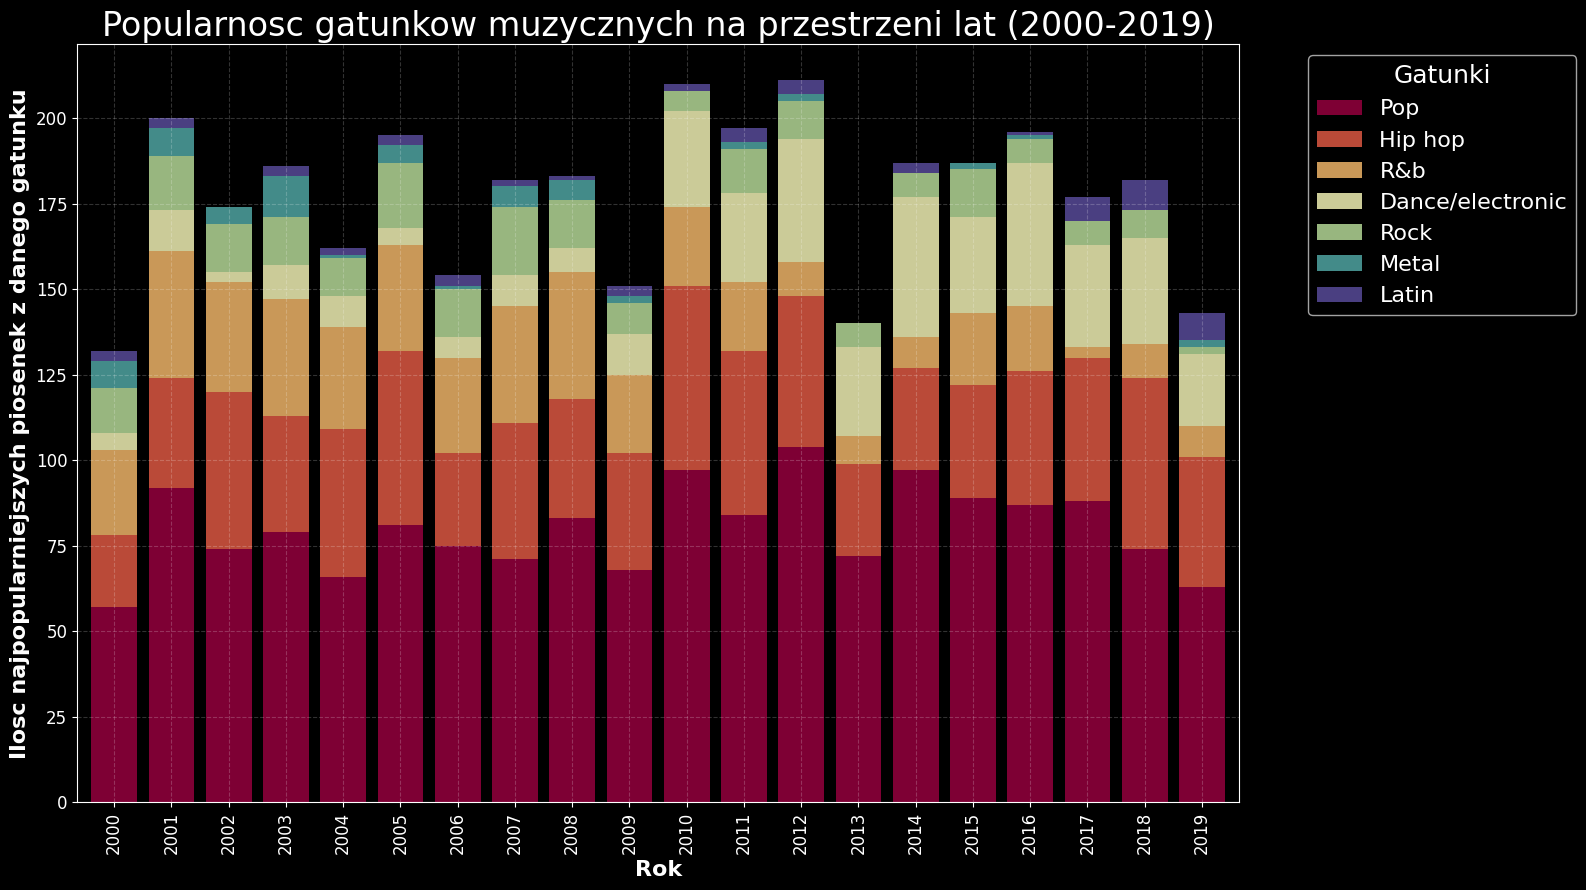

In [ ]:
# DANE
aktualne_dane = songnormalize

# TRANSFORMACJA DANYCH
# Funkcja zliczajaca piosenki wzg gatunku co rok.
aktualne_dane['genre'] = aktualne_dane['genre'].apply(lambda x: x.capitalize())

def licz_gatunki(aktualne_dane):
    zliczone_gatunki = {}  # slownik: przetrzymuje liczby piosenek dla kazdego gatunku w kazdym roku

    for year in set(aktualne_dane['year']):
        year_aktualne_dane = aktualne_dane[aktualne_dane['year'] == year]
        all_gatunki = []  # lista na gatunki w danym roku

        for gatunki in year_aktualne_dane['genre']:
            if not pd.isna(gatunki):
                # Split i dodaje do listy, transformujac na capitalized
                all_gatunki += [gatunek.capitalize() for gatunek in gatunki.split(', ')]

        zliczone_gatunki[year] = {}
        for gatunek in all_gatunki:
            if gatunek in zliczone_gatunki[year]:
                zliczone_gatunki[year][gatunek] += 1  # +=1 jesli gatunek juz istnieje
            else:
                zliczone_gatunki[year][gatunek] = 1  # dodaj nowy gatunek jesli nie istnije

    return zliczone_gatunki

# Filtr danych
pofiltrowane_aktualne_dane = aktualne_dane[(aktualne_dane['year'] > 1999) & (aktualne_dane['year'] <= 2019)]

pofiltrowane_zliczone_gatunki = licz_gatunki(pofiltrowane_aktualne_dane)
pofiltrowane_gatunek_df = pd.DataFrame(pofiltrowane_zliczone_gatunki).fillna(0)

# TOP 7 Gatunkow
top_gatunki = pofiltrowane_gatunek_df.sum(axis=1).sort_values(ascending=False).head(7).index
# Filtruje DataFrame zeby uwzglednic tylko top 7 gatunkow
top_gatunki_df = pofiltrowane_gatunek_df.loc[top_gatunki]
top_gatunki_df
# STYL I KOLORY
plt.style.use('dark_background')
kolory = cm.get_cmap('Spectral', len(top_gatunki))
lista_kolorow = [kolory(i) for i in range(len(top_gatunki))]

# WYKRES
ax = top_gatunki_df.T.plot(kind='bar', width=0.8, stacked=True, figsize=(16, 9), alpha=0.8, edgecolor='none', color=lista_kolorow)
plt.title('Popularnosc gatunkow muzycznych na przestrzeni lat (2000-2019)', fontsize=24)
plt.xlabel('Rok', fontsize=16, fontweight='bold')
plt.grid(True, alpha=0.2, linestyle='--')
plt.ylabel('Ilosc najpopularniejszych piosenek z danego gatunku', fontsize=16, fontweight='bold')
plt.legend(title='Gatunki', title_fontsize=18, fontsize=16, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tick_params(axis='both', labelsize=12)
plt.tight_layout()
plt.show()

#  **BUBBLECHART - top obserwowani i sluchani**

**Obserwujacy**

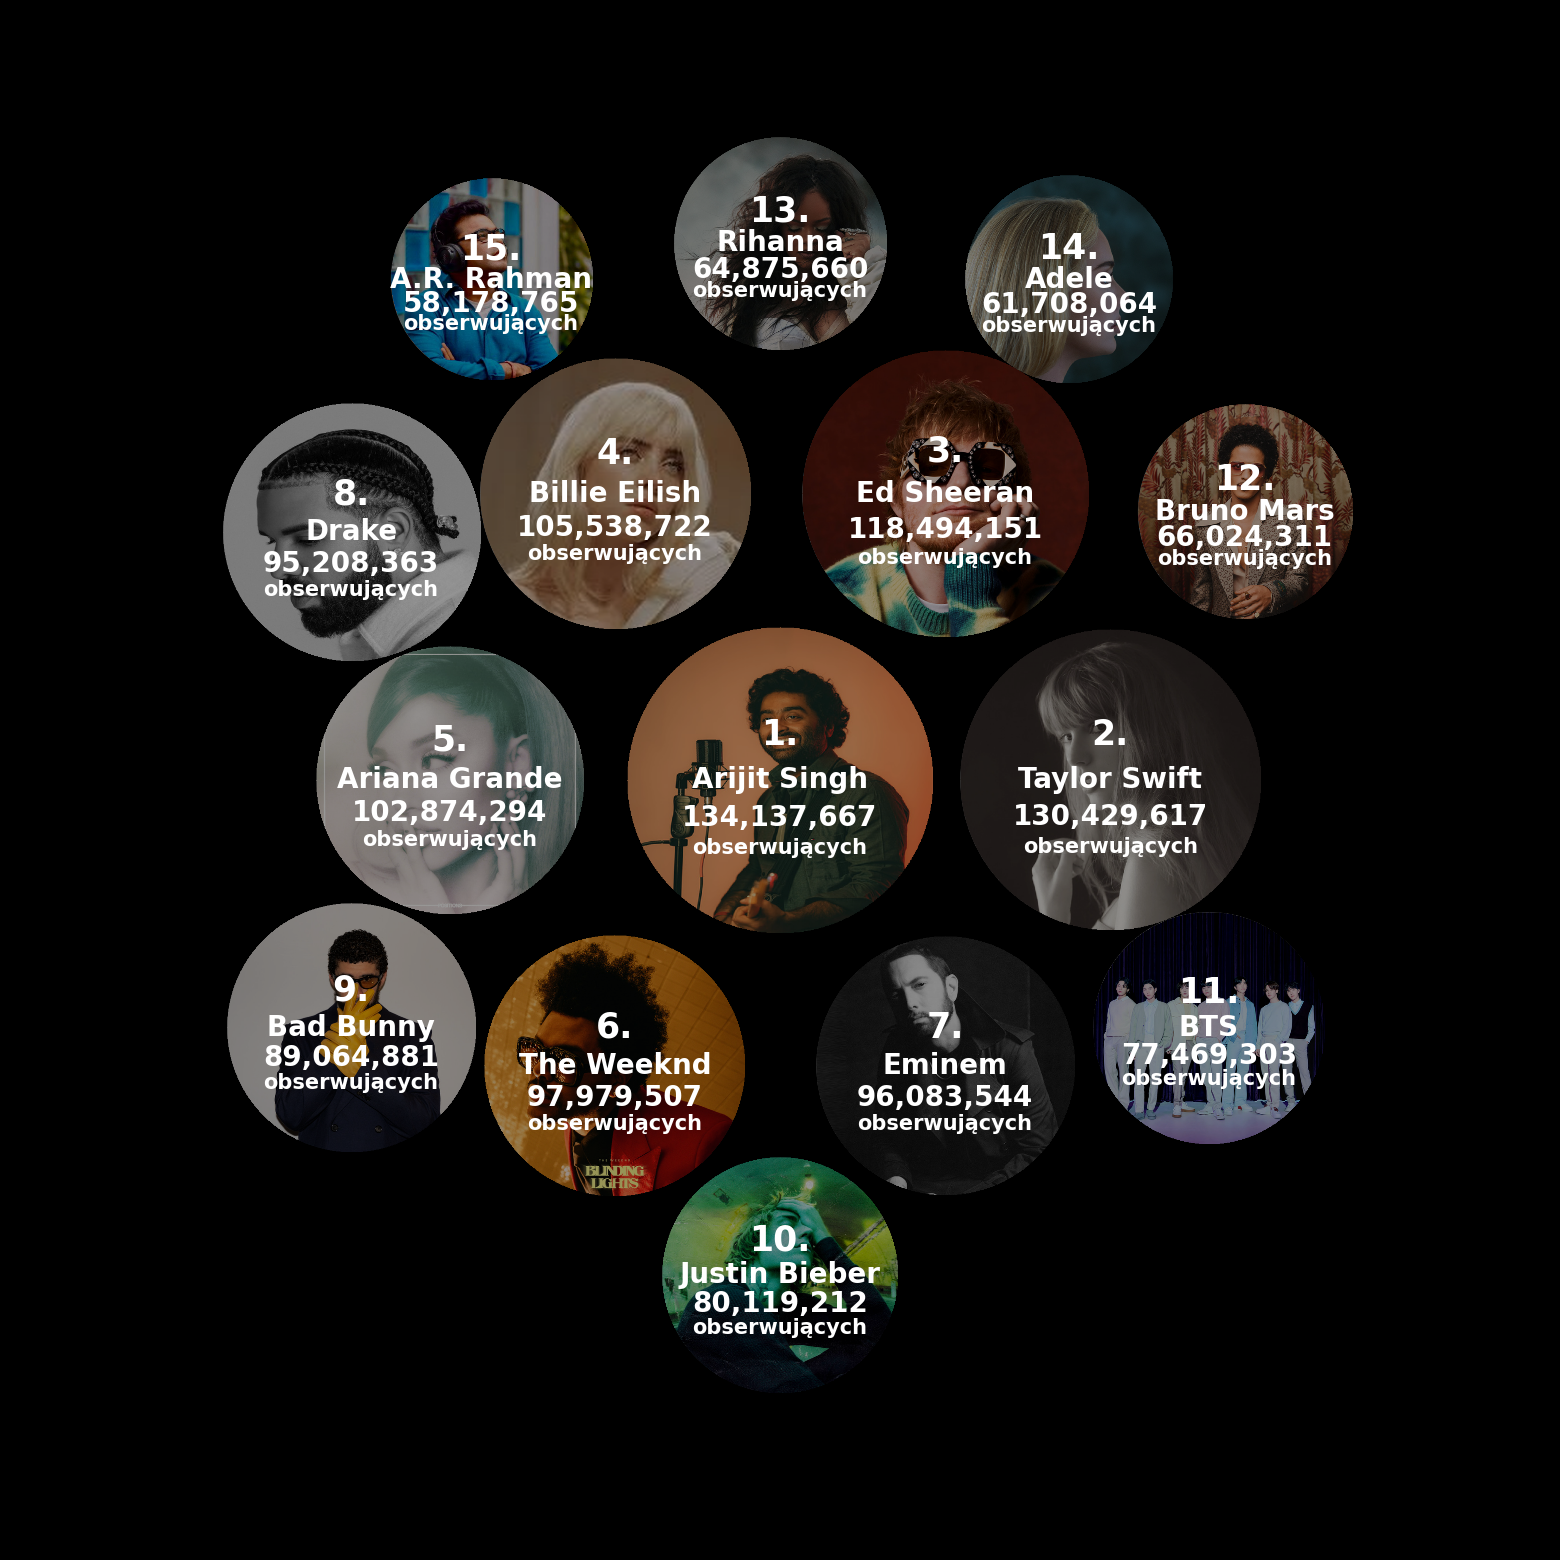

In [ ]:
# DANE
aktualne_dane = artist_followers


# TRANFORMACJA DANYCH
  # Zmiana na liczbe
aktualne_dane['Followers'] = aktualne_dane['Followers'].replace({',': ''}, regex=True).astype(int)
top_artists = aktualne_dane.nlargest(15, 'Followers')

# Normalizacja wielkości bąbli
bubble_size_factor = 1e7  # Zmniejszenie wielkości bąbli
size_reference = 375  # Referencyjny rozmiar bąbli

top_artists['Bubble_Size'] = np.sqrt(top_artists['Followers'] / bubble_size_factor)  # Dopasowanie do referencyjnego rozmiaru

# FUNKCJE
# Funkcja sprawdzająca, czy dwa bąble się nachodzą
def is_overlapping(x1, y1, r1, x2, y2, r2):
    distance = np.sqrt((x1 - x2)**2 + (y1 - y2)**2)
    return distance < (r1 + r2)

# Algorytm rozmieszczania bąbli w spiralę
def place_bubbles(artists):
    positions = []
    angle_increment = np.pi / 6  # Inkrementacja kąta w spiralnym układzie
    radius_increment = 1  # Odległość między kolejnymi warstwami
    current_angle = 0
    current_radius = 0

    for index, artist in artists.iterrows():
        r = artist['Bubble_Size']

        while True:
            # Wyznaczanie pozycji w układzie biegunowym
            x = current_radius * np.cos(current_angle)
            y = current_radius * np.sin(current_angle)

            # Sprawdź, czy bąbel nie nachodzi na inne
            overlap = any(is_overlapping(x, y, r, px, py, pr) for px, py, pr in positions)
            if not overlap:
                positions.append((x, y, r))
                break

            # Zwiększanie kąta i promienia
            current_angle += angle_increment
            if current_angle >= 2 * np.pi:  # Przejście do kolejnej warstwy
                current_angle = 0
                current_radius += radius_increment

    return positions

# Pozycje bąbli
positions = place_bubbles(top_artists)
#KOLORY  I PLAETY
plt.style.use('dark_background')


# WYKRES
  # Tworzenie wykresu
fig, ax = plt.subplots(figsize=(40, 20))  # Ustawienie wymiarów wykresu
ax.set_facecolor('black')
ax.set_aspect('equal')  # Zapewnienie równych proporcji osi
ax.axis('off')

  # Dynamiczne skalowanie osi
bubble_positions = np.array([(x, y, r) for x, y, r in positions])
max_extent = np.max(bubble_positions[:, :2] + bubble_positions[:, 2].reshape(-1, 1)) * 1.2
ax.set_xlim(-max_extent, max_extent)
ax.set_ylim(-max_extent, max_extent)

  # Rysowanie bąbli
for (x, y, r), (idx, artist) in zip(positions, top_artists.iterrows()):
    # Rysowanie bąbla
    bubble = plt.Circle((x, y), r, color='gray', alpha=0.7)
    ax.add_artist(bubble)

    # Dodanie obrazu artysty
    image_path = os.path.join(zdjecia_obs, f"{artist['Index']}.jpg")
    if os.path.exists(image_path):
        try:
            # Wczytanie obrazu i konwersja do RGBA (z kanałem alpha)
            image = Image.open(image_path).convert('RGBA')

            # Zmniejszenie jasności obrazu
            enhancer = ImageEnhance.Brightness(image)
            image = enhancer.enhance(0.6)   # Zmniejszenie jasności o 40%

            # Dopasowanie rozmiaru obrazu
            image = image.resize((500, 500), Image.Resampling.LANCZOS)
            image_np = np.array(image)

            # Tworzenie maski w kształcie okręgu
            y_mask, x_mask = np.ogrid[:image_np.shape[0], :image_np.shape[1]]
            mask = (x_mask - image_np.shape[1] // 2) ** 2 + (y_mask - image_np.shape[0] // 2) ** 2
            circle_mask = mask <= (image_np.shape[0] // 2) ** 2

            # Ustawianie przezroczystości na piksele poza kołem
            image_np[:, :, 3] = (circle_mask * 255).astype(np.uint8)

            # Obliczenie odpowiedniego współczynnika zoom dla obrazu
            zoom_factor = 60 * r / image.size[0]  # Dopasowanie średnicy bąbla do rozmiaru obrazu
            imagebox = OffsetImage(image_np, zoom=zoom_factor)
            ab = AnnotationBbox(imagebox, (x, y), frameon=False)
            ax.add_artist(ab)

        except Exception as e:
            print(f"Error processing image {image_path}: {e}")
    else:
        print(f"Image not found: {image_path}")

    # Dodanie tekstu na środku bąbla z indeksem
    ax.text(x, y + r*0.3, f"{idx + 1}.", ha='center', va='center', fontsize=25, color='white', weight='bold')
    ax.text(x, y, f"{artist['Artist']}", ha='center', va='center', fontsize=20, color='white', weight='bold')
    ax.text(x, y - r * 0.25, f"{artist['Followers']:,}", ha='center', va='center', fontsize=20, color='white', weight='bold')
    ax.text(x, y - r * 0.45, f"obserwujących", ha='center', va='center', fontsize=15, color='white', weight='bold')

plt.show()

In [ ]:
# DANE
aktualne_dane = arist_listeners

# Konwersja Followers na liczbę
aktualne_dane['Listeners'] = aktualne_dane['Listeners'].replace({',': ''}, regex=True)
aktualne_dane['Listeners'] = pd.to_numeric(aktualne_dane['Listeners'], errors='coerce')

  # Wybranie top 15 artystów według liczby Listeners
top_artists = aktualne_dane.nlargest(15, 'Listeners')

  # Normalizacja wielkości bąbli
bubble_size_factor = 1e7  # Zmniejszenie wielkości bąbli
size_reference = 375  # Referencyjny rozmiar bąbli

top_artists['Bubble_Size'] = np.sqrt(top_artists['Listeners'] / bubble_size_factor)  # Dopasowanie do referencyjnego rozmiaru

  # Funkcja sprawdzająca, czy dwa bąble się nachodzą
def is_overlapping(x1, y1, r1, x2, y2, r2):
    distance = np.sqrt((x1 - x2)**2 + (y1 - y2)**2)
    return distance < (r1 + r2)

  # Algorytm rozmieszczania bąbli w spiralę
def place_bubbles(artists):
    positions = []
    angle_increment = np.pi / 6  # Inkrementacja kąta w spiralnym układzie
    radius_increment = 1  # Odległość między kolejnymi warstwami
    current_angle = 0
    current_radius = 0

    for index, artist in artists.iterrows():
        r = artist['Bubble_Size']

        while True:
            # Wyznaczanie pozycji w układzie biegunowym
            x = current_radius * np.cos(current_angle)
            y = current_radius * np.sin(current_angle)

            # Sprawdź, czy bąbel nie nachodzi na inne
            overlap = any(is_overlapping(x, y, r, px, py, pr) for px, py, pr in positions)
            if not overlap:
                positions.append((x, y, r))
                break

            # Zwiększanie kąta i promienia
            current_angle += angle_increment
            if current_angle >= 2 * np.pi:  # Przejście do kolejnej warstwy
                current_angle = 0
                current_radius += radius_increment

    return positions

  # Pozycje bąbli
positions = place_bubbles(top_artists)

  # Obrót o 90 stopni w lewo
rotated_positions = [(-y, x, r) for x, y, r in positions]
#KOLORY I  MAPY

plt.style.use('dark_background')

# WYKRES

fig, ax = plt.subplots(figsize=(40, 20))  # Ustawienie wymiarów wykresu
ax.set_facecolor('black')  # Czarne tło
ax.set_aspect('equal')  # Zapewnienie równych proporcji osi
ax.axis('off')

  # Dynamiczne skalowanie osi
bubble_positions = np.array([(x, y, r) for x, y, r in rotated_positions])
max_extent = np.max(bubble_positions[:, :2] + bubble_positions[:, 2].reshape(-1, 1)) * 1.2
ax.set_xlim(-max_extent, max_extent)
ax.set_ylim(-max_extent, max_extent)

  # Rysowanie bąbli
for (x, y, r), (idx, artist) in zip(rotated_positions, top_artists.iterrows()):
    # Rysowanie bąbla
    bubble = plt.Circle((x, y), r, color='black', alpha=0.7)
    ax.add_artist(bubble)

    # Dodanie obrazu artysty
    image_path = os.path.join(zdjecia_sluchacze, f"{artist['Index']}.jpg")
    if os.path.exists(image_path):
        try:
            # Wczytanie obrazu i konwersja do RGBA (z kanałem alpha)
            image = Image.open(image_path).convert('RGBA')

            # Zmniejszenie jasności obrazu
            enhancer = ImageEnhance.Brightness(image)
            image = enhancer.enhance(0.6)  # Zmniejszenie jasności o 20%

            # Dopasowanie rozmiaru obrazu
            image = image.resize((500, 500), Image.Resampling.LANCZOS)
            image_np = np.array(image)

            # Tworzenie maski w kształcie okręgu
            y_mask, x_mask = np.ogrid[:image_np.shape[0], :image_np.shape[1]]
            mask = (x_mask - image_np.shape[1] // 2) ** 2 + (y_mask - image_np.shape[0] // 2) ** 2
            circle_mask = mask <= (image_np.shape[0] // 2) ** 2

            # Ustawianie przezroczystości na piksele poza kołem
            image_np[:, :, 3] = (circle_mask * 255).astype(np.uint8)

            # Obliczenie odpowiedniego współczynnika zoom dla obrazu
            zoom_factor = 80 * r / image.size[0]  # Dopasowanie średnicy bąbla do rozmiaru obrazu
            imagebox = OffsetImage(image_np, zoom=zoom_factor)
            ab = AnnotationBbox(imagebox, (x, y), frameon=False)
            ax.add_artist(ab)

        except Exception as e:
            print(f"Error processing image {image_path}: {e}")
    else:
        print(f"Image not found: {image_path}")

    # Dodanie tekstu na środku bąbla z indeksem
    ax.text(x, y + r*0.2, f"{idx + 1}.", ha='center', va='center', fontsize=25, color='white', weight='bold')
    ax.text(x, y, f"{artist['Artist']}", ha='center', va='center', fontsize=25, color='white', weight='bold')
    ax.text(x, y - r * 0.2, f"{artist['Listeners']:,}", ha='center', va='center', fontsize=22, color='white', weight='bold')
    ax.text(x, y - r * 0.4, f"miesięcznych sluchaczy", ha='center', va='center', fontsize=15, color='white', weight='bold')

plt.tight_layout()
plt.show()


Output hidden; open in https://colab.research.google.com to view.

# **PIECHART - kraje pochodzenia top followed artystow**

<ipython-input-18-8dc903e2d5d4>:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('tab10', len(top_panstwa_pl))


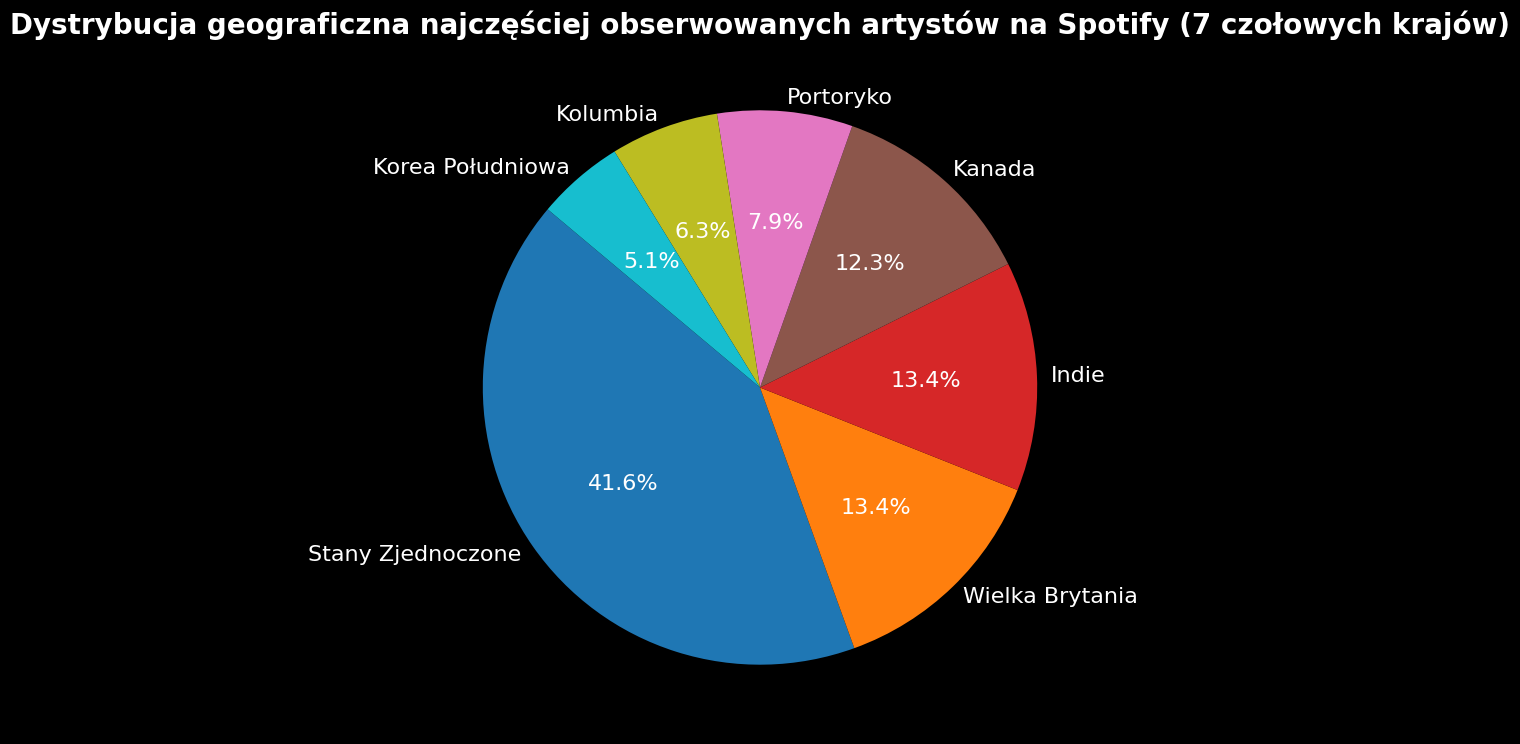

In [ ]:
#DANE
aktualne_dane = most_followed

#TRANSFORMACJA DANYCH

kraje_dystrybucja = aktualne_dane.groupby('Country')['Followers'].sum()

top_panstwa = kraje_dystrybucja.sort_values(ascending=False).head(7)
slownik = {
    "United States": "Stany Zjednoczone",
    "United Kingdom": "Wielka Brytania",
    "Colombia": "Kolumbia",
    "South Korea": "Korea Południowa",
    "Canada": "Kanada",
    "India": "Indie",
    "Puerto Rico": "Portoryko",

}
top_panstwa_pl = top_panstwa.rename(index=slownik)

#STYL I KOLORY
plt.style.use('dark_background')

colormap = cm.get_cmap('tab10', len(top_panstwa_pl))
colors = [mcolors.rgb2hex(colormap(i)[:3]) for i in range(len(top_panstwa_pl))]
#WYKRES
plt.figure(figsize=(16,9))
top_panstwa_pl.plot.pie(
    autopct='%1.1f%%',
    startangle=140,
    labeldistance=1.05,
    fontsize=16,
    colors=colors
)
plt.title('Dystrybucja geograficzna najczęściej obserwowanych artystów na Spotify (7 czołowych krajów)', fontsize=20,weight='bold')
plt.ylabel('')
plt.show()







# **SPRZEDAZ**

**KOLORMAPA DO SPRZEDAZY**

In [ ]:
# Połączenie unikalnych formatów z obu zbiorów danych
# Lista unikalnych formatów (przetłumaczonych)
formats_translated = [
    'Taśma 8-ścieżkowa',
    'Płyta CD',
    'Kaseta',
    'Album do pobrania',
    'Singiel do pobrania',
    'Płyta winylowa (LP/EP)',
    'Teledysk (fizyczny)',
    'Płatna subskrypcja',
    'Dystrybucje SoundExchange',
    'Singiel winylowy',
    'Inne cyfrowe'  # Jeśli występuje w danych sprzedaży
]

# Tworzenie kolormapy
colormap = plt.get_cmap('tab20b', len(formats_translated))  # Użycie kolormapy 'tab20'
color_dict = {format: mcolors.to_hex(colormap(i)) for i, format in enumerate(formats_translated)}  # Mapowanie

# Kolory dla formatów
print(color_dict)  # Weryfikacja słownika

** PRZYCHODY **

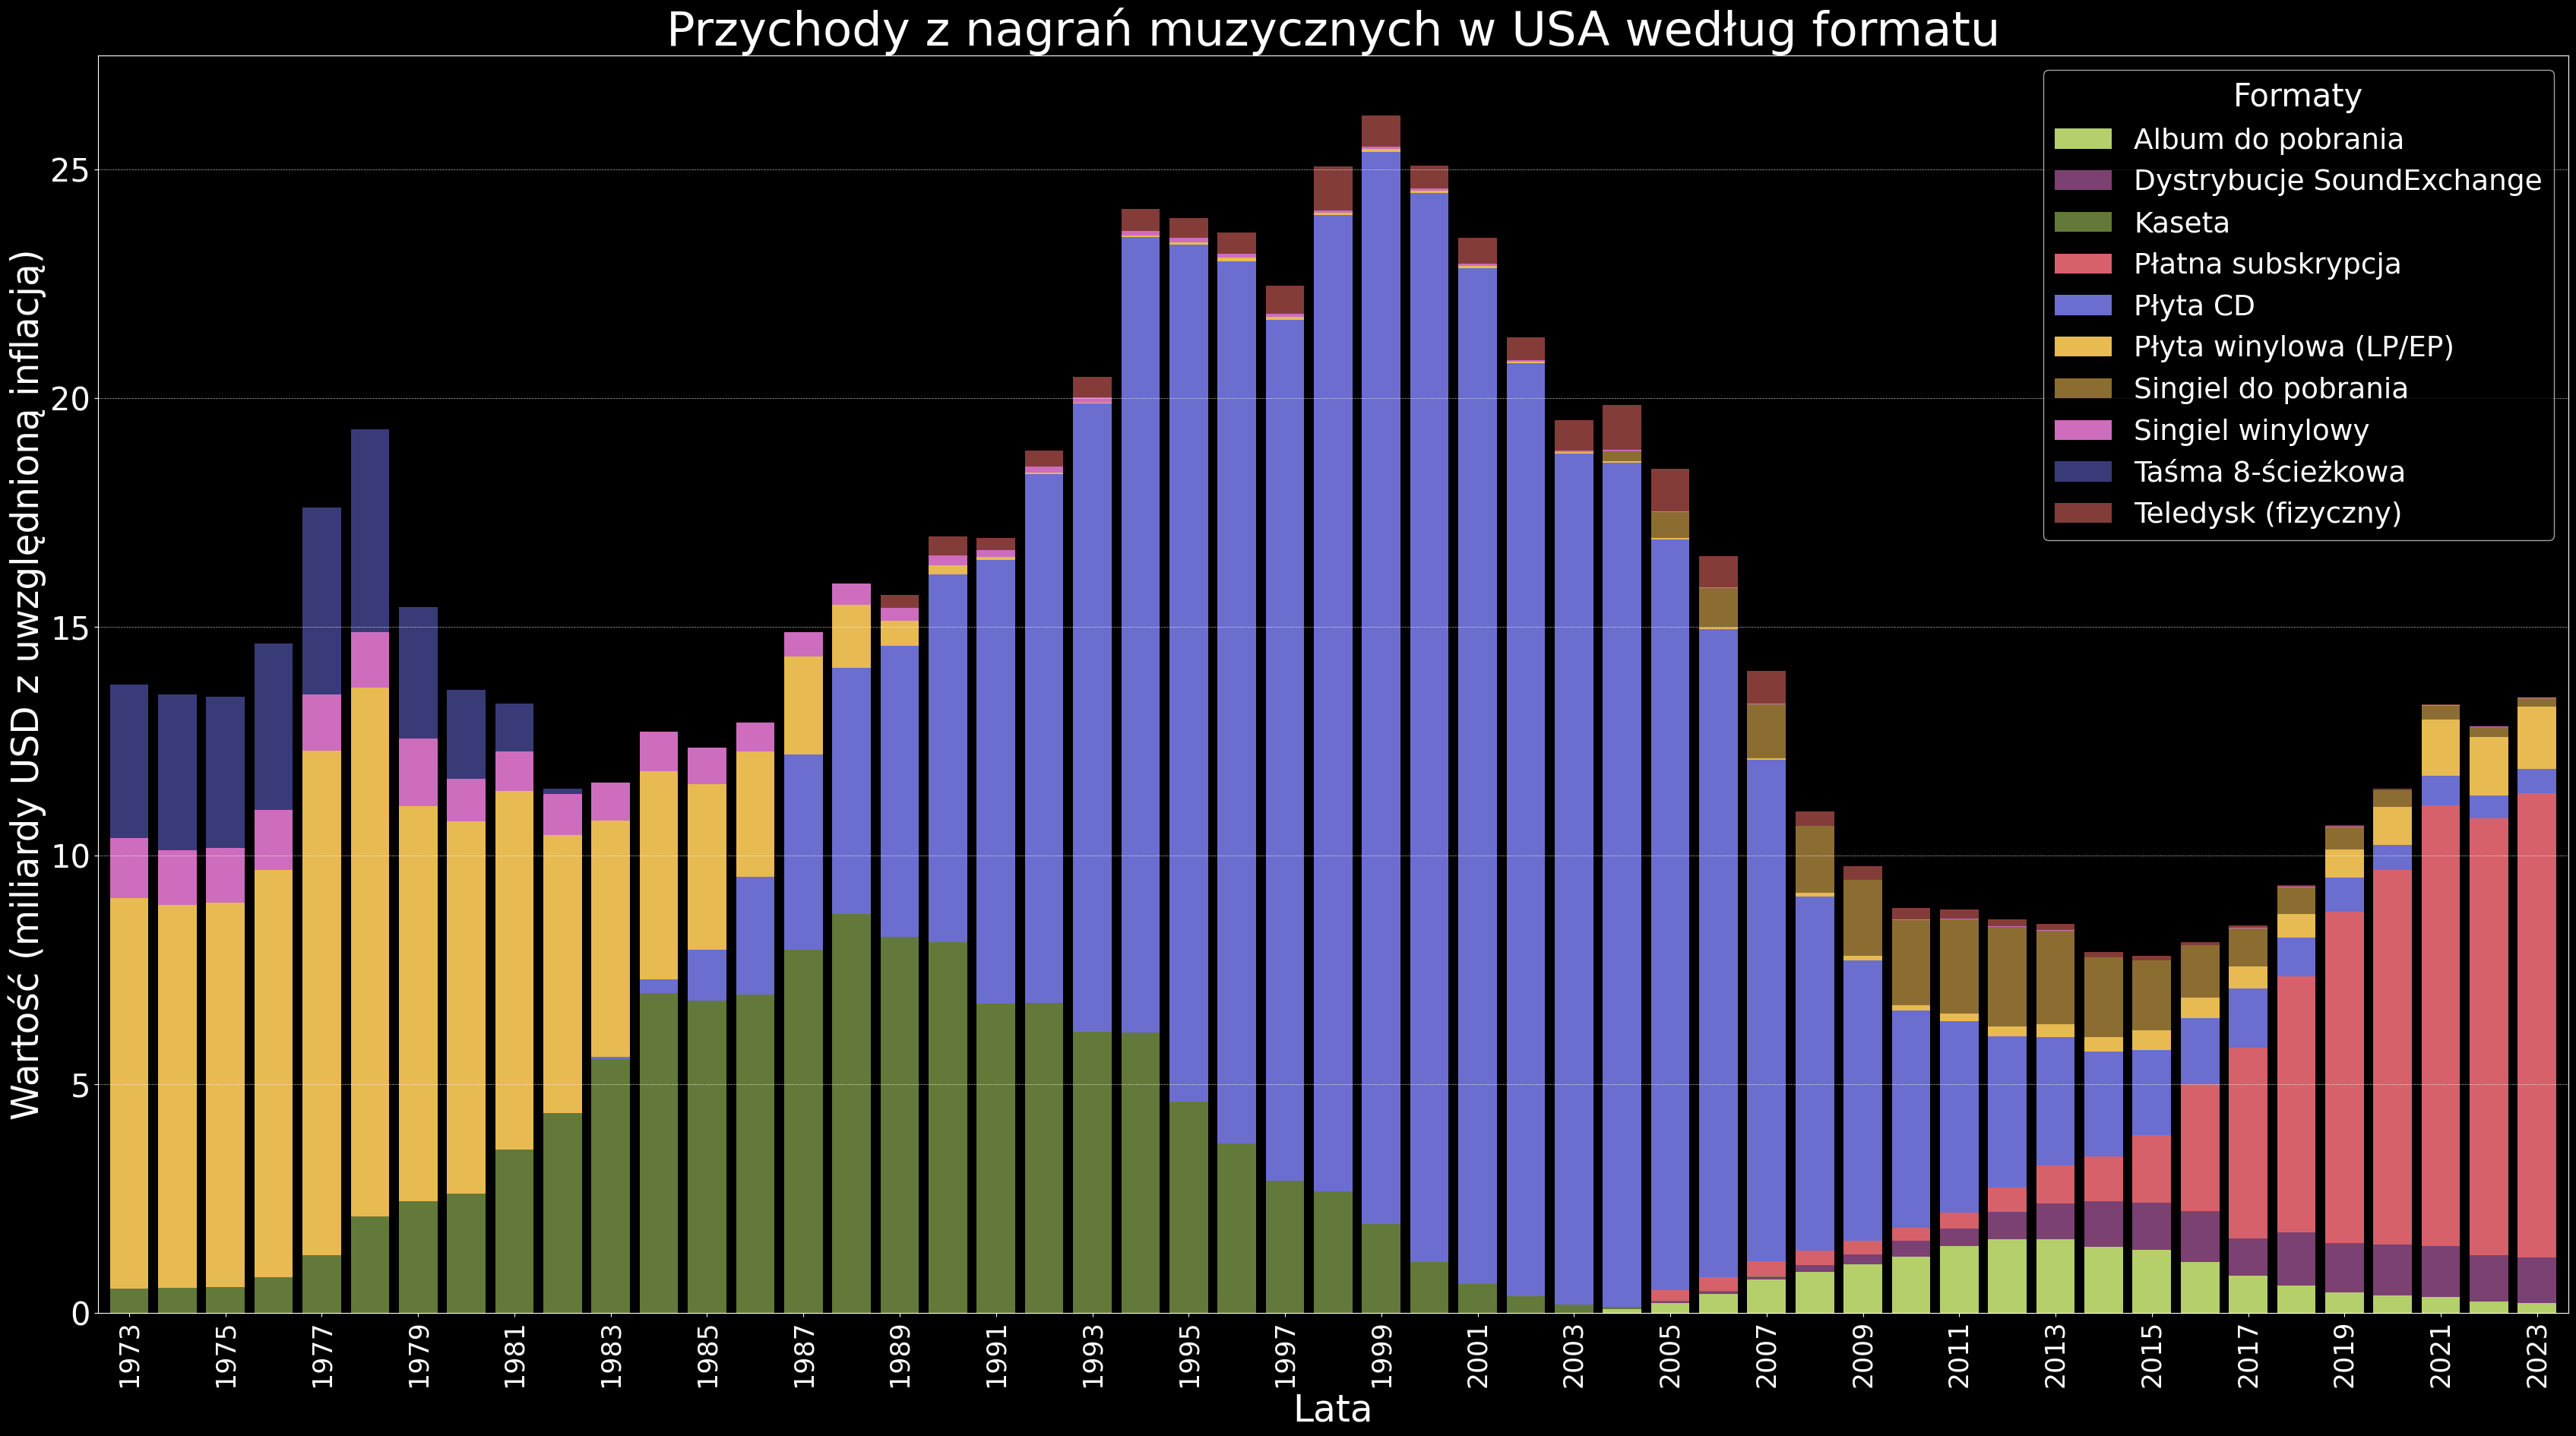

In [ ]:

# DANE
aktualne_dane = revenue
# TRANFORMACJA DANYCH
# Wybór istotnych kolumn
data_filtered = aktualne_dane[['Year (copy)', 'Value (For Charting)', 'Format']].dropna()
data_filtered.columns = ['Year', 'Value', 'Format']  # Uproszczenie nazw kolumn
data_filtered['Year'] = data_filtered['Year'].astype(int)  # Konwersja na int
data_filtered['Value'] = data_filtered['Value'].astype(float)  # Konwersja na float

# Tłumaczenie formatów na język polski
translation_dict = {
    '8 - Track': 'Taśma 8-ścieżkowa',
    'CD': 'Płyta CD',
    'Cassette': 'Kaseta',
    'Download Album': 'Album do pobrania',
    'Download Single': 'Singiel do pobrania',
    'LP/EP': 'Płyta winylowa (LP/EP)',
    'Music Video (Physical)': 'Teledysk (fizyczny)',
    'Paid Subscription': 'Płatna subskrypcja',
    'SoundExchange Distributions': 'Dystrybucje SoundExchange',
    'Vinyl Single': 'Singiel winylowy',
}
data_filtered['Format'] = data_filtered['Format'].map(translation_dict)

# Podsumowanie wartości dla każdego formatu
total_by_format = data_filtered.groupby('Format')['Value'].sum().sort_values(ascending=False)

# Wybór 10 najważniejszych formatów
top_formats = total_by_format.head(10).index

# Filtrowanie danych
filtered_data = data_filtered[data_filtered['Format'].isin(top_formats)].copy()
filtered_data['ValueBln'] = filtered_data['Value'].apply(lambda x: x / 1000)

# Przygotowanie danych do wykresu
pivot_data = filtered_data.pivot_table(
    index='Year', columns='Format', values='ValueBln', aggfunc='sum', fill_value=0
)

# STYL I KOLORY
plt.style.use('dark_background')

# Generowanie mapy kolorów
unique_formats = list(pivot_data.columns)


# Generowanie wykresu
fig, ax = plt.subplots(figsize=(34, 19))
# colors_aktualne_dane = [color_dict[format] for format in pivot_data.columns]  # Dopasowanie kolorów
pivot_data.plot(kind='bar', stacked=True, ax=ax, width=0.8, color=color_dict, edgecolor='none')  # Usunięcie obramowań

# Dodanie siatki
ax.grid(visible=True, which='major', axis='y', linestyle='--', linewidth=0.5, alpha=0.7)  # Siatka pozioma
ax.grid(visible=False, axis='x')  # Ukrycie siatki pionowej

# Dostosowanie wykresu
ax.set_title('Przychody z nagrań muzycznych w USA według formatu', fontsize=45)
ax.set_ylabel('Wartość (miliardy USD z uwzględnioną inflacją)', fontsize=35)
ax.set_xlabel('Lata', fontsize=35)

# Wyświetlanie tylko co 5 lat na osi X
display_years = pivot_data.index[::2]  # Wybierz co 2 rok

ax.set_xticks(range(0, len(pivot_data.index), 2))  # Lokacje co 2 lata
ax.set_xticklabels(display_years, rotation=90, fontsize=25)
ax.tick_params(axis='y', labelsize=30)

# Przeniesienie legendy
ax.legend(title='Formaty', loc='upper right', fontsize=27, title_fontsize=30)
fig.tight_layout()

# Wyświetlenie wykresu
plt.show()


**ILOSC SPRZEDAZY**

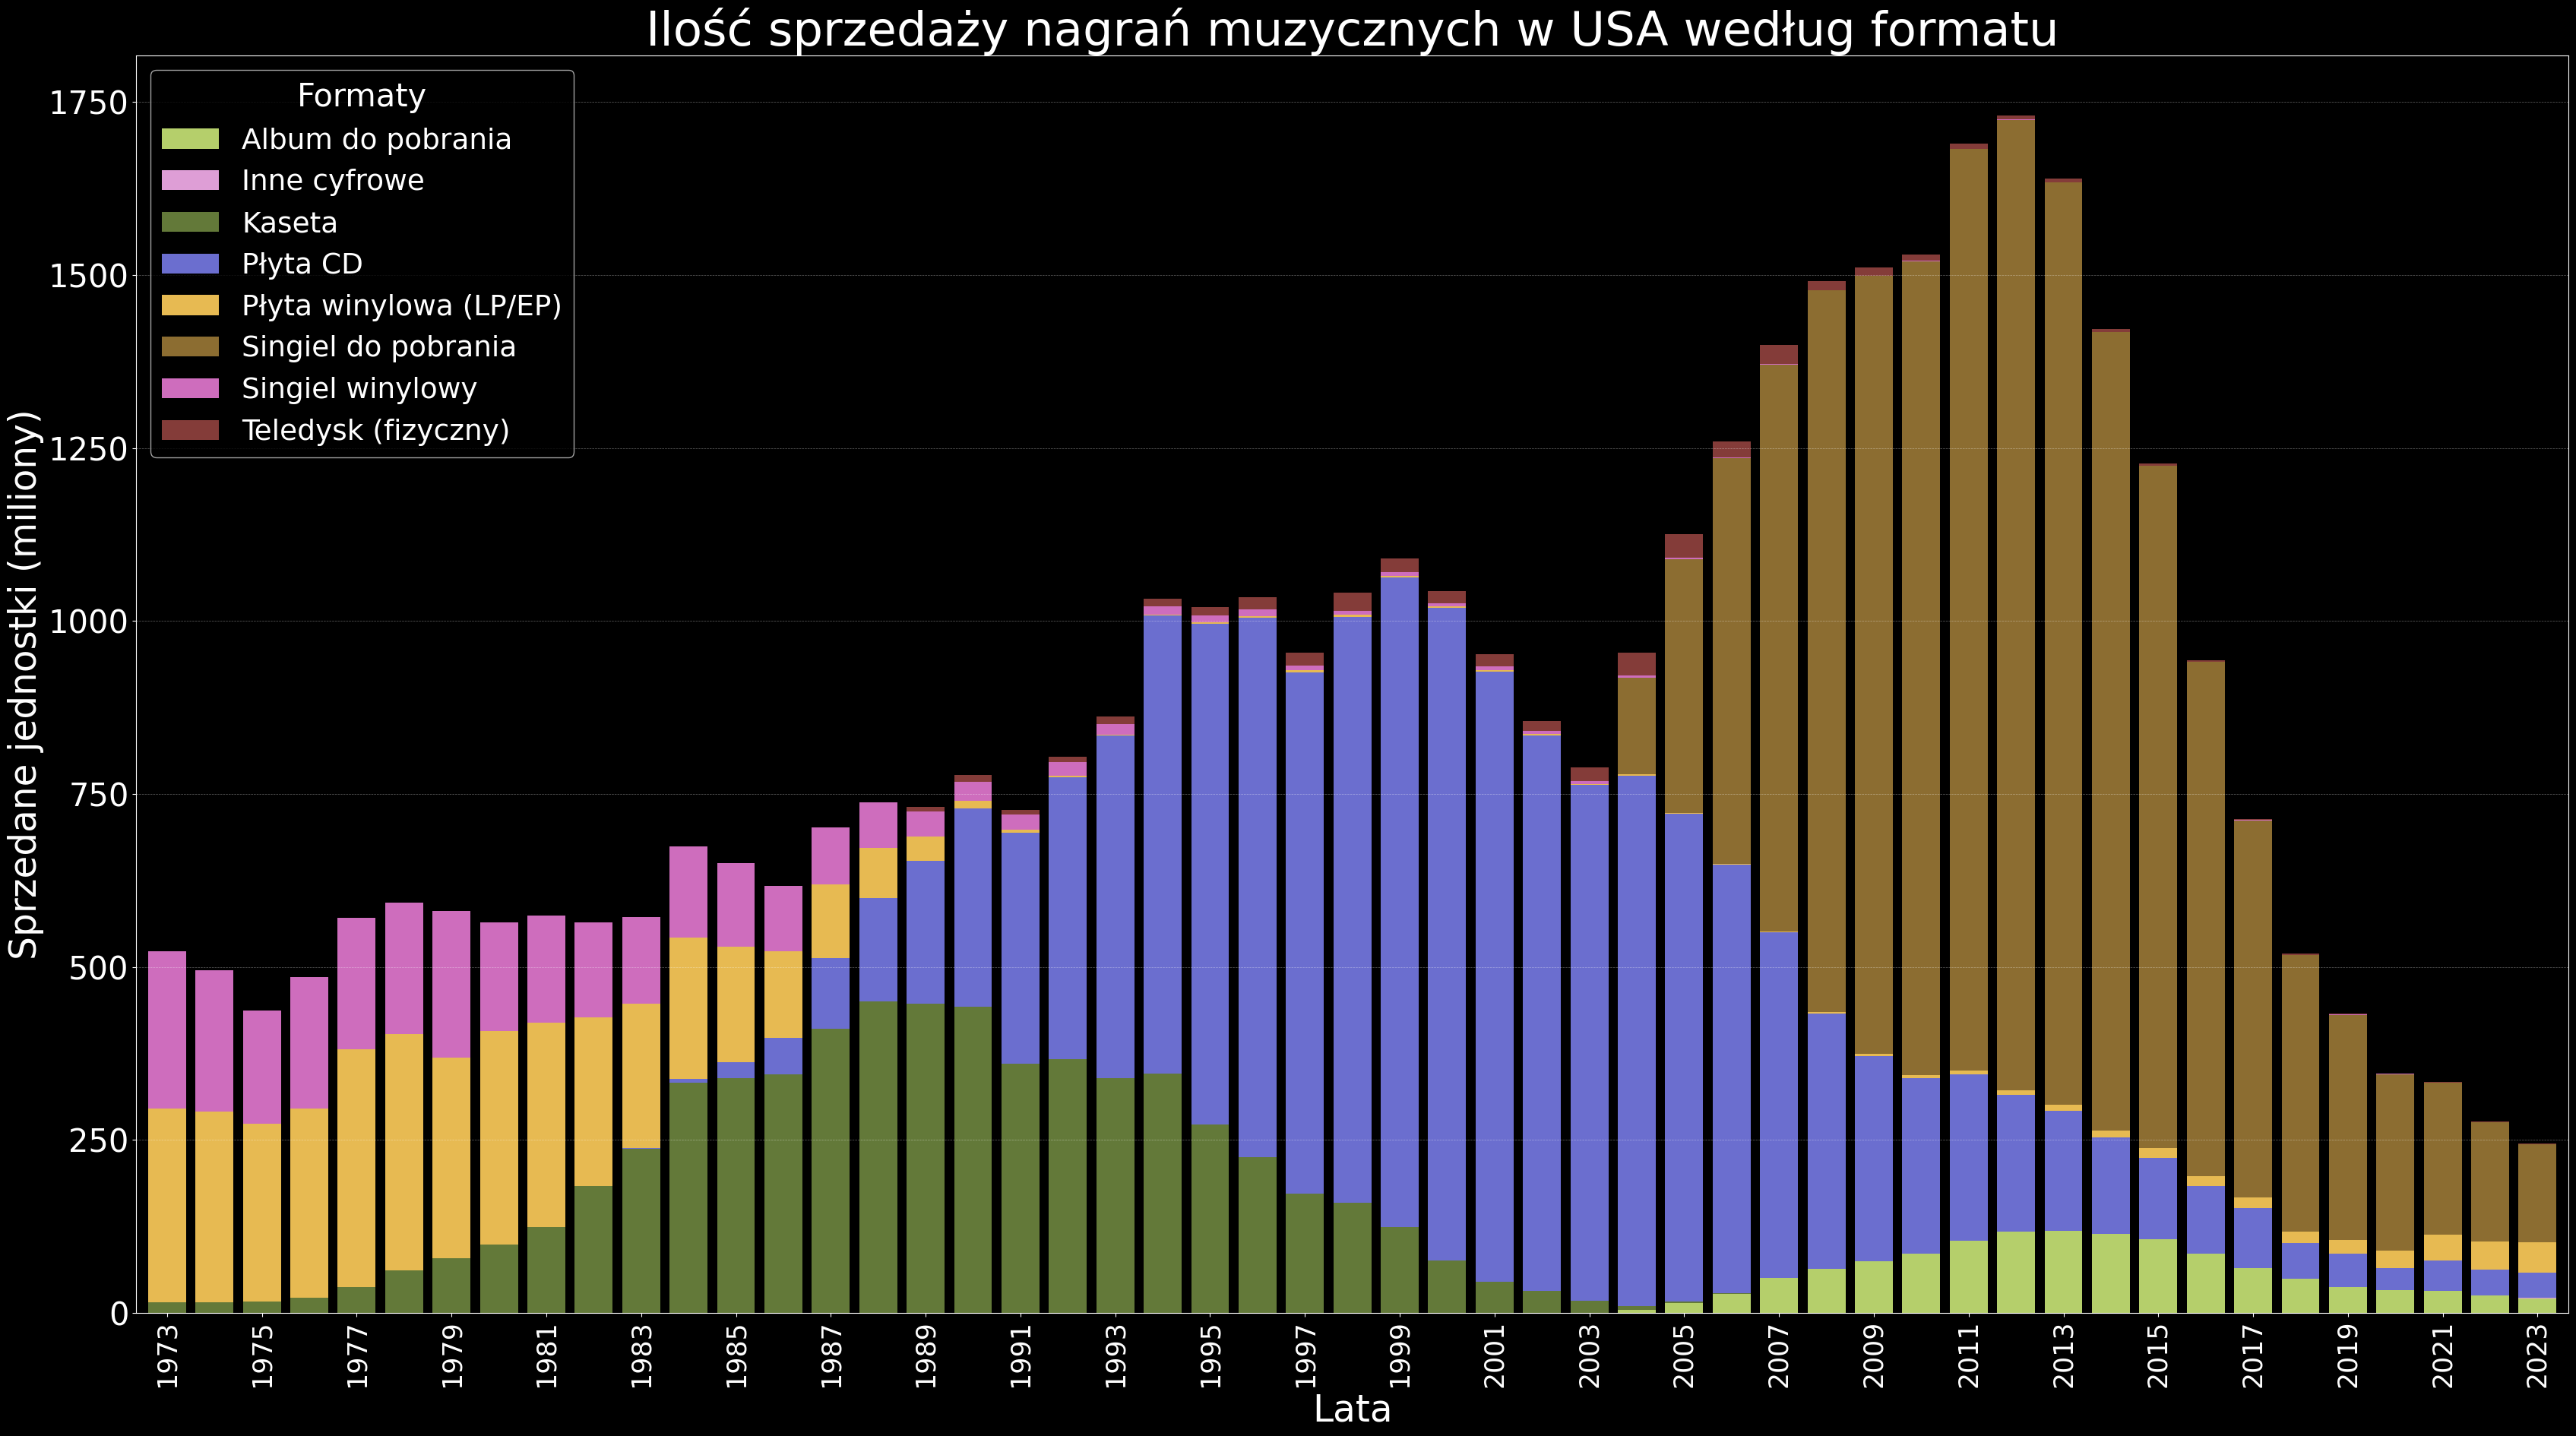

In [ ]:

# Wczytanie danych
sales_volume_path = r'G:\My Drive\Studia\FILES\PRZEDMIOTY\WizualizacjaDanych\Projects\Music\Datasets\Sales Volume Chart_data.csv'
aktualne_dane = sales_volume

# TRANFORMACJA DANYCH
  # Wybór istotnych kolumn
sales_filtered = aktualne_dane[['Year (copy)', 'Value (Actual)', 'Format']].dropna()
sales_filtered.columns = ['Year', 'Value', 'Format']  # Uproszczenie nazw kolumn
sales_filtered['Year'] = sales_filtered['Year'].astype(int)  # Konwersja na int
sales_filtered['Value'] = sales_filtered['Value'].astype(float)  # Konwersja na float

# Tłumaczenie formatów na język polski
sales_translation_dict = {
    'Other Digital': 'Inne cyfrowe',
    'CD': 'Płyta CD',
    'Cassette': 'Kaseta',
    'Download Album': 'Album do pobrania',
    'Download Single': 'Singiel do pobrania',
    'LP/EP': 'Płyta winylowa (LP/EP)',
    'Music Video (Physical)': 'Teledysk (fizyczny)',
    'Paid Subscription': 'Płatna subskrypcja',
    'SoundExchange Distributions': 'Dystrybucje SoundExchange',
    'Vinyl Single': 'Singiel winylowy',
}
sales_filtered['Format'] = sales_filtered['Format'].map(sales_translation_dict)

  # Podsumowanie wartości dla każdego formatu
total_by_format_sales = sales_filtered.groupby('Format')['Value'].sum().sort_values(ascending=False)

  # Wybór 10 najważniejszych formatów
top_formats_sales = total_by_format_sales.head(10).index

  # Filtrowanie danych
filtered_sales_data = sales_filtered[sales_filtered['Format'].isin(top_formats_sales)].copy()
filtered_sales_data['ValueB'] = filtered_sales_data['Value']

  # Przygotowanie danych do wykresu
pivot_sales_data = filtered_sales_data.pivot_table(
    index='Year', columns='Format', values='ValueB', aggfunc='sum', fill_value=0
)

# STYL I KOLORY
plt.style.use('dark_background')

# Generowanie wykresu
fig, ax = plt.subplots(figsize=(34, 19))
pivot_sales_data.plot(kind='bar', stacked=True, ax=ax, width=0.8, color=color_dict, edgecolor='none')  # Usunięcie obramowań

# Dodanie przezroczystej siatki
ax.grid(visible=True, which='major', axis='y', linestyle='--', linewidth=0.5, alpha=0.4)  # Siatka pozioma
ax.grid(visible=False, axis='x')  # Ukrycie siatki pionowej

# Dostosowanie wykresu
ax.set_title('Ilość sprzedaży nagrań muzycznych w USA według formatu', fontsize=45)
ax.set_ylabel('Sprzedane jednostki (miliony)', fontsize=35)
ax.set_xlabel('Lata', fontsize=35)

# Wyświetlanie tylko co 2 lata na osi X
display_years = pivot_sales_data.index[::2]  # Wybierz co 2 rok
ax.set_xticks(range(0, len(pivot_sales_data.index), 2))  # Lokacje co 2 lata
ax.set_xticklabels(display_years, rotation=90, fontsize=25)
ax.tick_params(axis='y', labelsize=30)

# Przeniesienie legendy
ax.legend(title='Formaty', loc='upper left', fontsize=27, title_fontsize=30)
fig.tight_layout()

# Wyświetlenie wykresu
plt.show()


# **SCATTERPLOT - radio/sprzedaz**

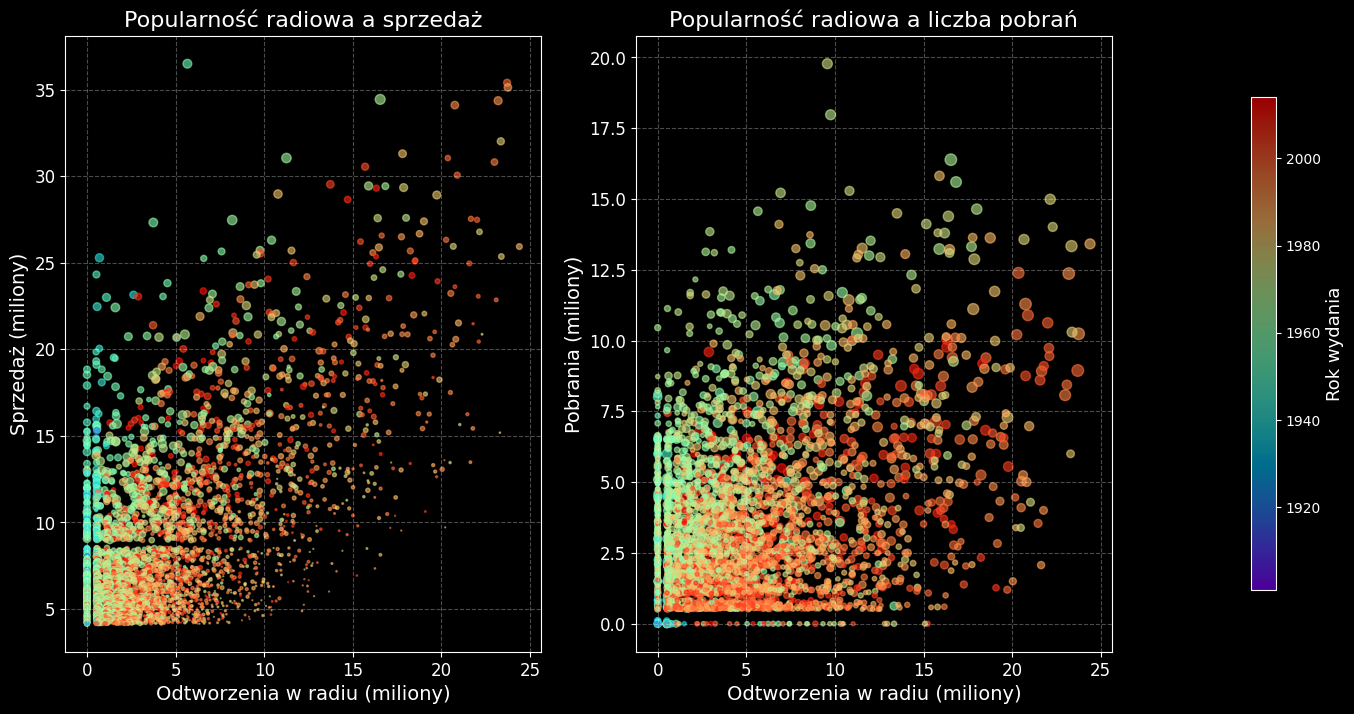

In [ ]:
#DANE
aktualne_dane = song

#Za pomocą plt.subplots(1, 2, figsize=(18, 8), sharey=True) powstaje figura z dwoma kolumnami wykresów
#(pierwsza i druga kolumna).
fig, axes = plt.subplots(1, 2, figsize=(18, 8), sharey=False) #Dzięki parametrowi sharey=True oba wykresy korzystają z tej samej skali na osi y.


#TRANSORMACJA DANYCH

#STYL I KOLORY
plt.style.use('dark_background')
#WYKRES
    # Tworzymy dwa wykresy
axes[0].tick_params(axis='both', labelsize=12) #pierwszy wykres
axes[1].tick_params(axis='both', labelsize=12) #drugi wykres
    # Wykres 1
scatter1 = axes[0].scatter(aktualne_dane['Radio Plays'],
    aktualne_dane['Sales'],
    c=aktualne_dane['Year'],
    s=aktualne_dane['Streams']*2,
    cmap='rainbow',
    alpha=0.6)
    # Wykres 1 podpisy
axes[0].set_title('Popularność radiowa a sprzedaż', fontsize=16)
axes[0].set_xlabel('Odtworzenia w radiu (miliony)', fontsize=14)
axes[0].set_ylabel('Sprzedaż (miliony)', fontsize=14)
axes[0].grid(True, linestyle='--', alpha=0.3)
    # Wykres 2
scatter2 = axes[1].scatter(
    aktualne_dane['Radio Plays'],
    aktualne_dane['Downloads'],
    c=aktualne_dane['Year'],
    s=aktualne_dane['Sales']*2,
    cmap='rainbow',
    alpha=0.6)
    # Wykres 2 podpisy
axes[1].set_title('Popularność radiowa a liczba pobrań', fontsize=16)
axes[1].set_xlabel('Odtworzenia w radiu (miliony)', fontsize=14)
axes[1].set_ylabel('Pobrania (miliony)', fontsize=14)
axes[1].tick_params(labelleft=True)
axes[1].grid(True, linestyle='--', alpha=0.3)
  # Colorbar
cbar = fig.colorbar(scatter1, ax=axes, location='right', shrink=0.8, pad=0.1)
cbar.set_label('Rok wydania', fontsize=13)

# **SCATTERPLOT - tonacja**


C:\Users\olima\AppData\Local\Temp\ipykernel_14776\2708001421.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='key', y='count', data=zlicz_tonacje, palette='viridis', edgecolor='none')


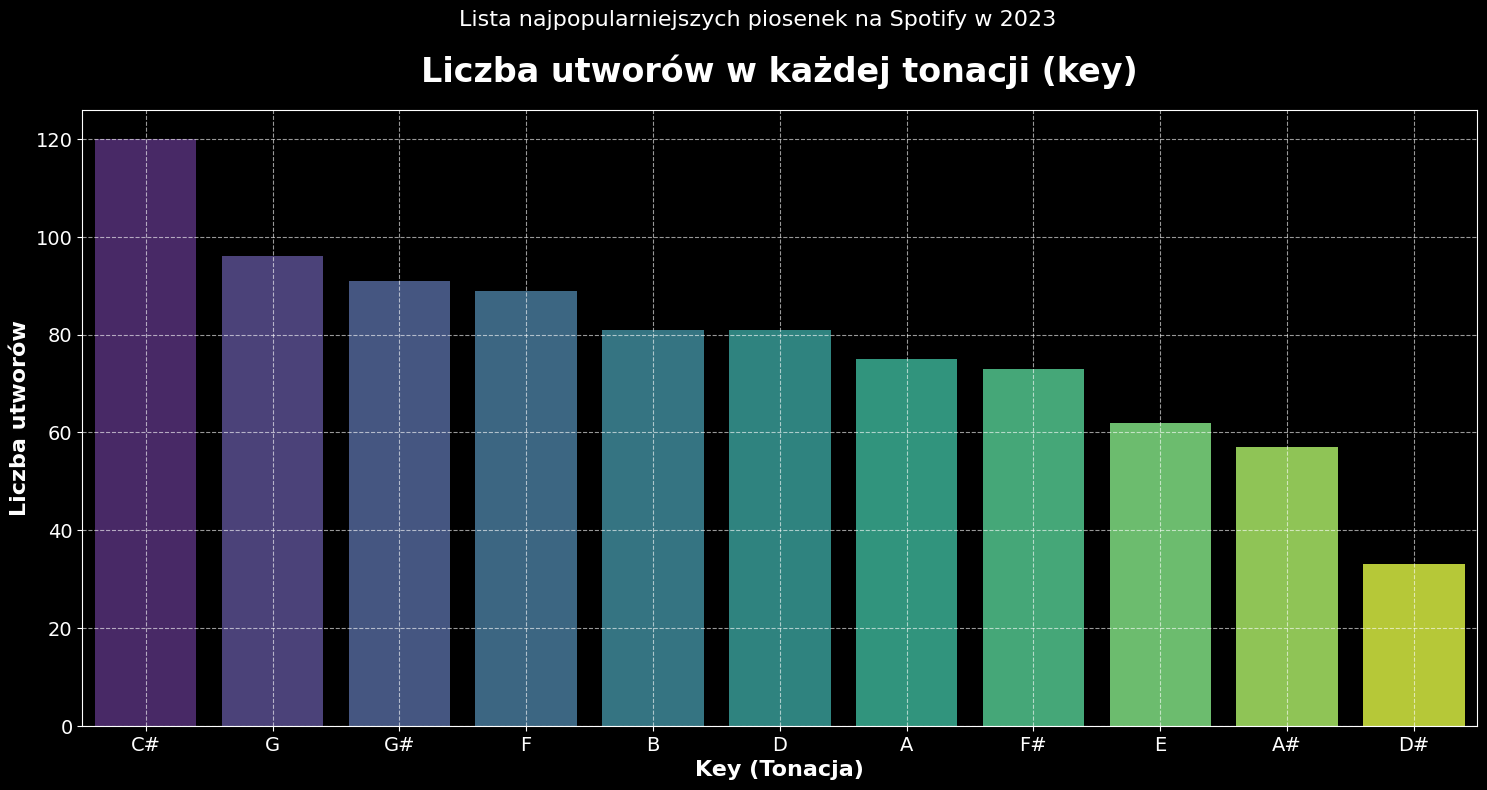

In [ ]:
#DANE
aktualne_dane = spotify_2023

#TRANSFORMACJA DANYCH
  # Grupujemy dane i liczymy liczbę utworów w każdej tonacji (key)
zlicz_tonacje = aktualne_dane['key'].value_counts().reset_index()
zlicz_tonacje.columns = ['key', 'count']

#STYL I KOLORY
plt.style.use('dark_background')

#WYKRES
  # Tworzymy wykres
plt.figure(figsize=(18, 8))

  # Wykres słupkowy (bar plot) z liczbą utworów w każdej tonacji
sns.barplot(x='key', y='count', data=zlicz_tonacje, palette='viridis', edgecolor='none')

  # Tytuly
plt.title('Liczba utworów w każdej tonacji (key)', fontsize=24, color='white', pad=20,fontweight='bold')
plt.suptitle('Lista najpopularniejszych piosenek na Spotify w 2023', fontsize=16, color='white', va='bottom')
plt.xlabel('Key (Tonacja)', fontsize=16, color='white',fontweight='bold')
plt.ylabel('Liczba utworów', fontsize=16, color='white',fontweight='bold')
  # Limity i ticki
plt.tick_params(axis='both', labelsize=14, color='white')

  # Siatka
plt.grid(True, linestyle='--', alpha=0.6, color='white')

plt.show()

# **SCATTERPLOT - BPM**

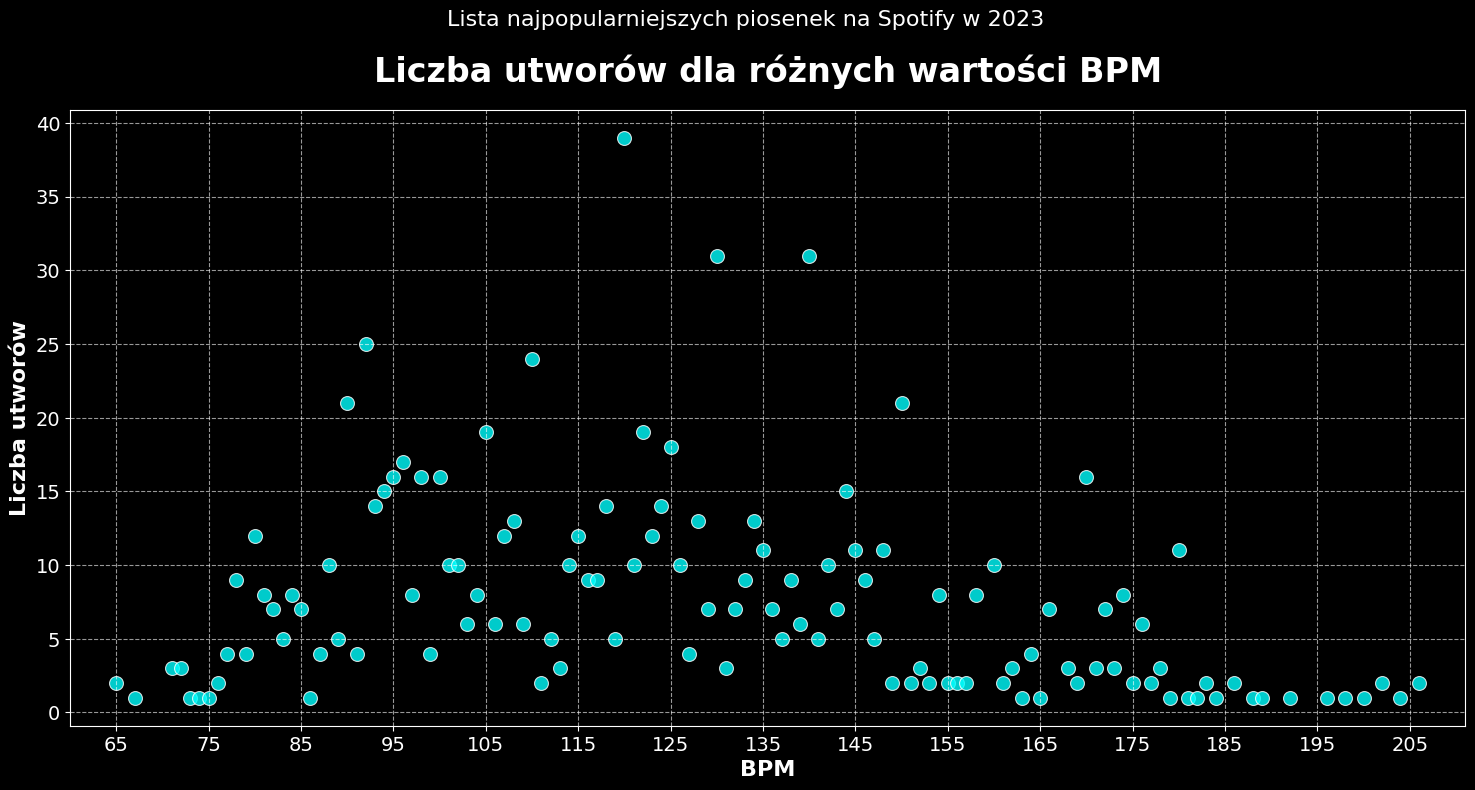

In [ ]:
#DANE
aktualne_dane = spotify_2023

#TRANSFORMACJA DANYCH
  # Grupujemy i zliczamy piosenki dla kaz dego bpm
zlicz_bpm = aktualne_dane['bpm'].value_counts().reset_index()
zlicz_bpm.columns = ['bpm', 'count']
zlicz_bpm = zlicz_bpm.sort_values(by='bpm')  # Sortujemy dane

#STYL I KOLORY
plt.style.use('dark_background')
#WYKRES
plt.figure(figsize=(18, 8))

  # Scatterplot
sns.scatterplot(x='bpm', y='count', data=zlicz_bpm, marker='o', s=100,
                edgecolor='white', color='cyan', alpha=0.8)

  # Limity i Ticki (x)
plt.xlim(zlicz_bpm['bpm'].min() - 5, zlicz_bpm['bpm'].max() + 5)
plt.xticks(range(zlicz_bpm['bpm'].min(), zlicz_bpm['bpm'].max() + 1, 10))

  # Tytuly i podpisy
plt.title('Liczba utworów dla różnych wartości BPM', fontsize=24, color='white', pad=20, fontweight='bold')
plt.suptitle('Lista najpopularniejszych piosenek na Spotify w 2023', fontsize=16, color='white', va='bottom')
plt.xlabel('BPM', fontsize=16, color='white', fontweight='bold')
plt.ylabel('Liczba utworów', fontsize=16, color='white', fontweight='bold')

  # Siatka
plt.tick_params(axis='both', labelsize=14, color='white')
plt.grid(True, linestyle='--', alpha=0.6, color='white')

plt.show()


# **HEXBIN - długosc tytułu**

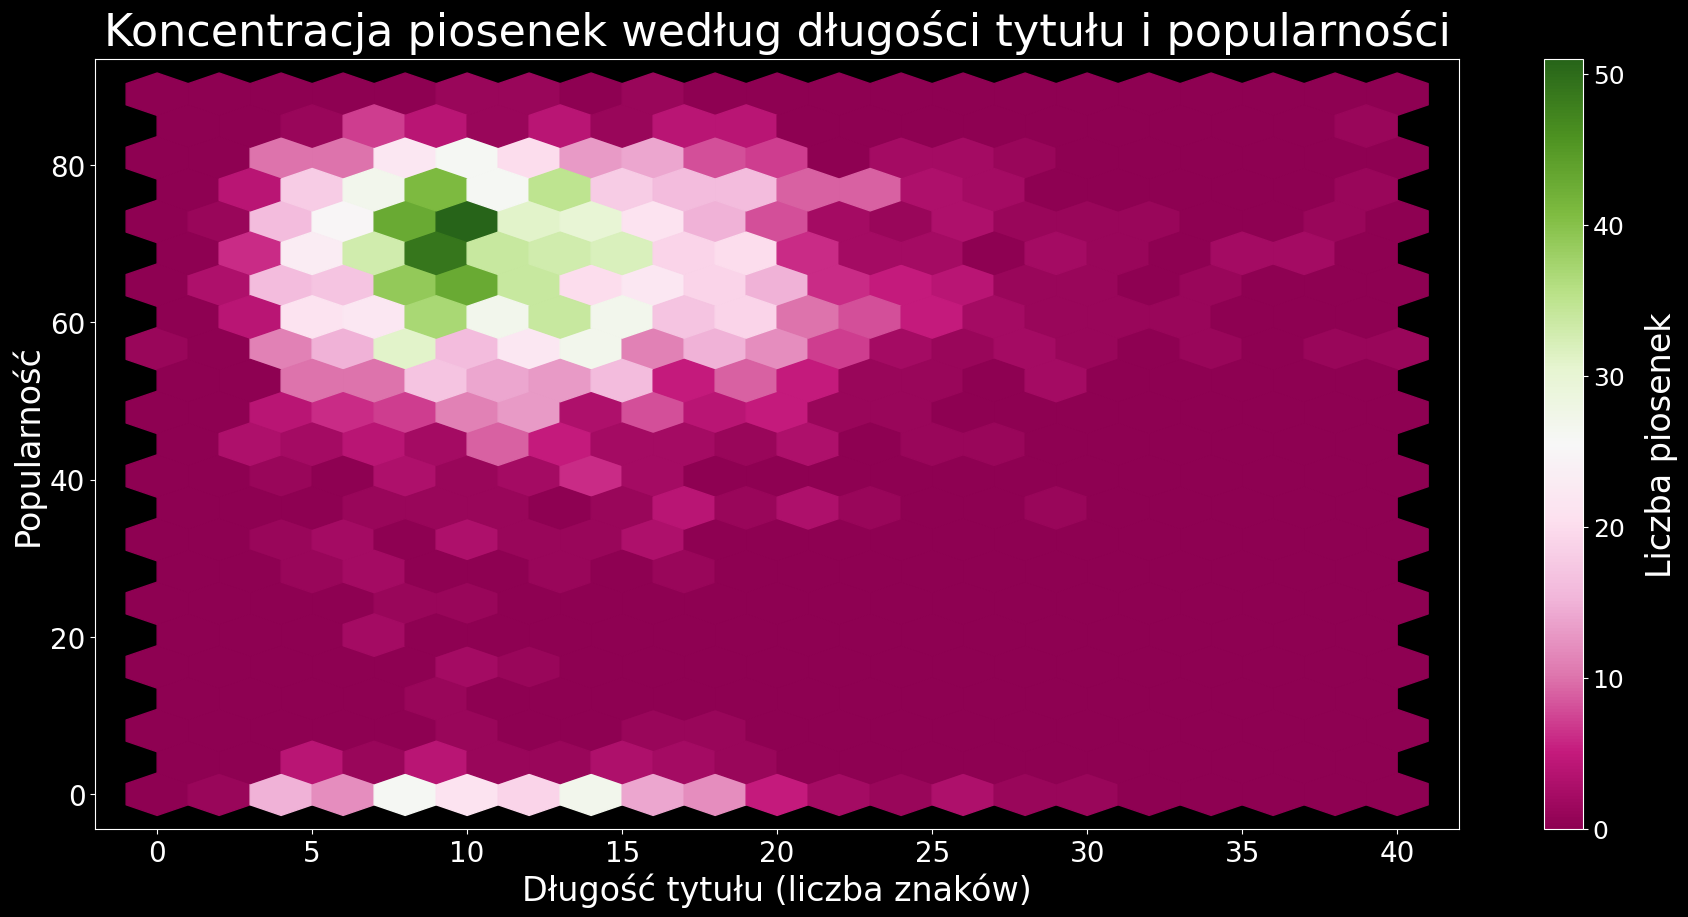

In [ ]:
import re
#DANE
aktualne_dane =  songnormalize

#Tranformacja danych
def czysc(title):
    # Usuń wszystko po pierwszym nawiasie, cudzysłowie lub myślniku
    czysty_tytul = re.split(r'\(|\[|"|-', title)[0]
    # Usuń nadmiarowe spacje na końcach
    czysty_tytul = czysty_tytul.strip()
    return len(czysty_tytul)

# Dodaj nową kolumnę z oczyszczoną długością tytułu
aktualne_dane['czysc'] = aktualne_dane['song'].apply(czysc)

# Dodaj kolumnę z oczyszczonymi tytułami
aktualne_dane['clean_title'] = aktualne_dane['song'].apply(lambda x: re.split(r'\(|\[|"|-', x)[0].strip())

#KOLORY
plt.style.use('dark_background')
#Wykres
plt.figure(figsize=(22, 10))
hex_plot = plt.hexbin(
    aktualne_dane['czysc'],
    aktualne_dane['popularity'],
    gridsize=20,
    cmap='PiYG'
)

# Tworzenie i dostosowywanie colorbara
colorbar = plt.colorbar(hex_plot)
colorbar.ax.tick_params(labelsize=18)
colorbar.set_label('Liczba piosenek', fontsize=24, color='white', labelpad=15)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Długość tytułu (liczba znaków)', fontsize=24)
plt.ylabel('Popularność', fontsize=24)

plt.title('Koncentracja piosenek według długości tytułu i popularności', fontsize=32, color='white', pad=10)


# **VIOLIN PLOT - taneczność**

<ipython-input-65-4f492fcd4037>:15: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




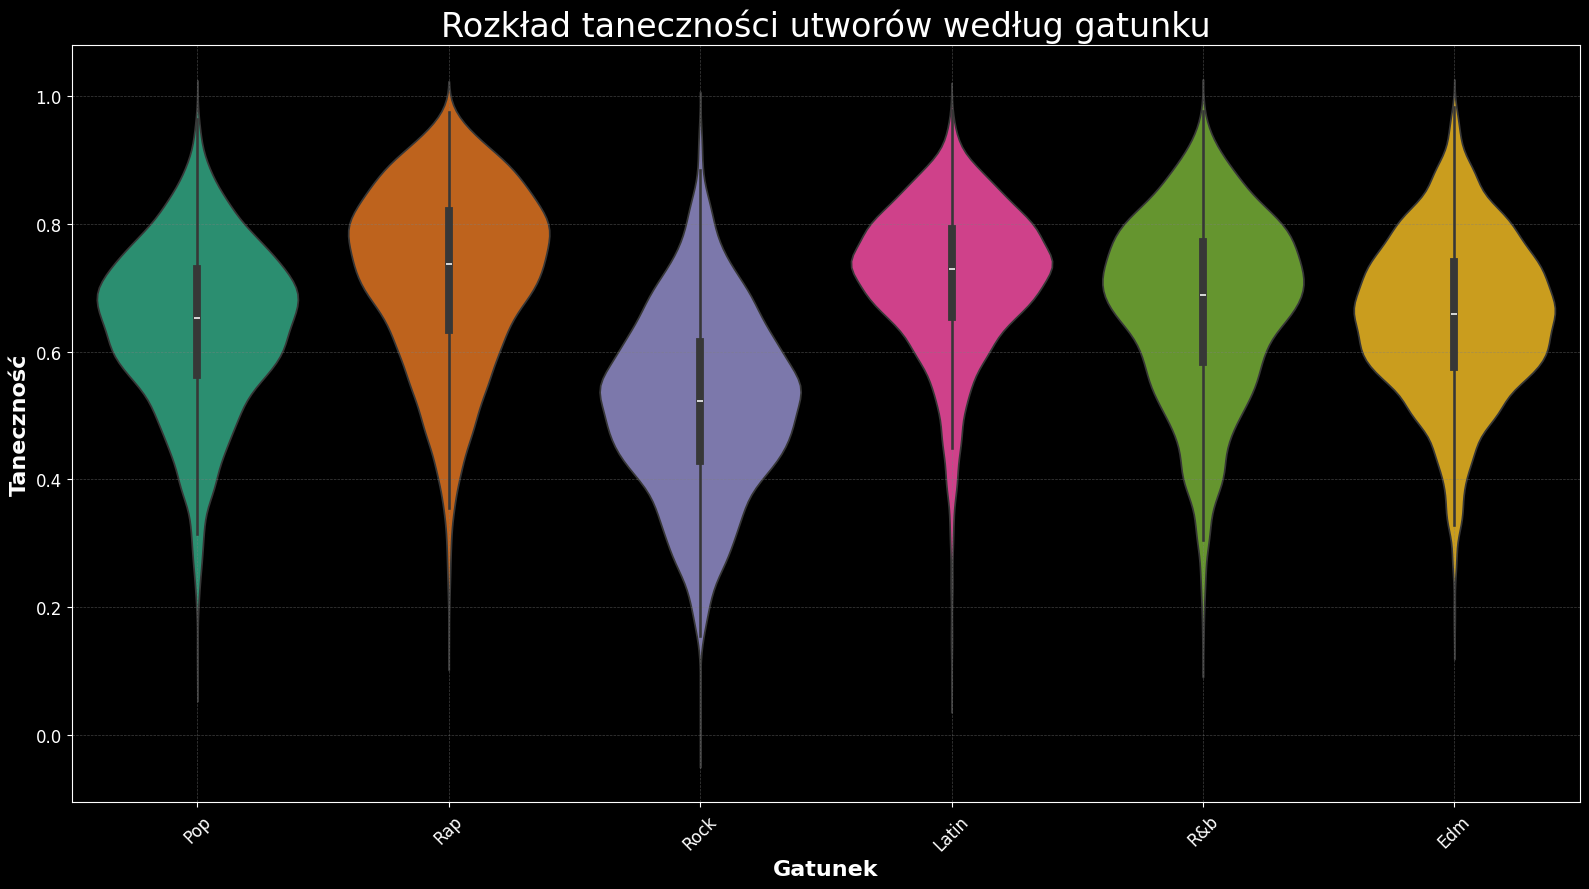

In [ ]:
#DANE
aktualne_dane = spotify_songs

#TRANSFORMACJA DANYCH
aktualne_dane['playlist_genre'] = aktualne_dane['playlist_genre'].apply(lambda x: x.capitalize())
gatunki = aktualne_dane['playlist_genre'].unique()

#STYL I KOLORY
plt.style.use('dark_background')
paleta = sns.color_palette("Dark2", len(gatunki))
mapa_kolorow = dict(zip(gatunki, paleta))
#WYKRES
fig, ax = plt.subplots(figsize=(16,9))
  # Tworzenie wykresu typu 'violin plot' dla taneczności według gatunku
sns.violinplot(data=aktualne_dane, x='playlist_genre', y='danceability', palette=mapa_kolorow, ax=ax)
  # Poprawa czytelności wykresu
ax.set_title('Rozkład taneczności utworów według gatunku', fontsize=24)
ax.set_xlabel('Gatunek', fontsize=16,weight='bold')
ax.set_ylabel('Taneczność', fontsize=16,weight='bold')
ax.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.5)

plt.xticks(rotation=45)
plt.tick_params(axis='both', labelsize=12)
plt.tight_layout()
plt.show()

# **STACKPLOT - wulgarność**

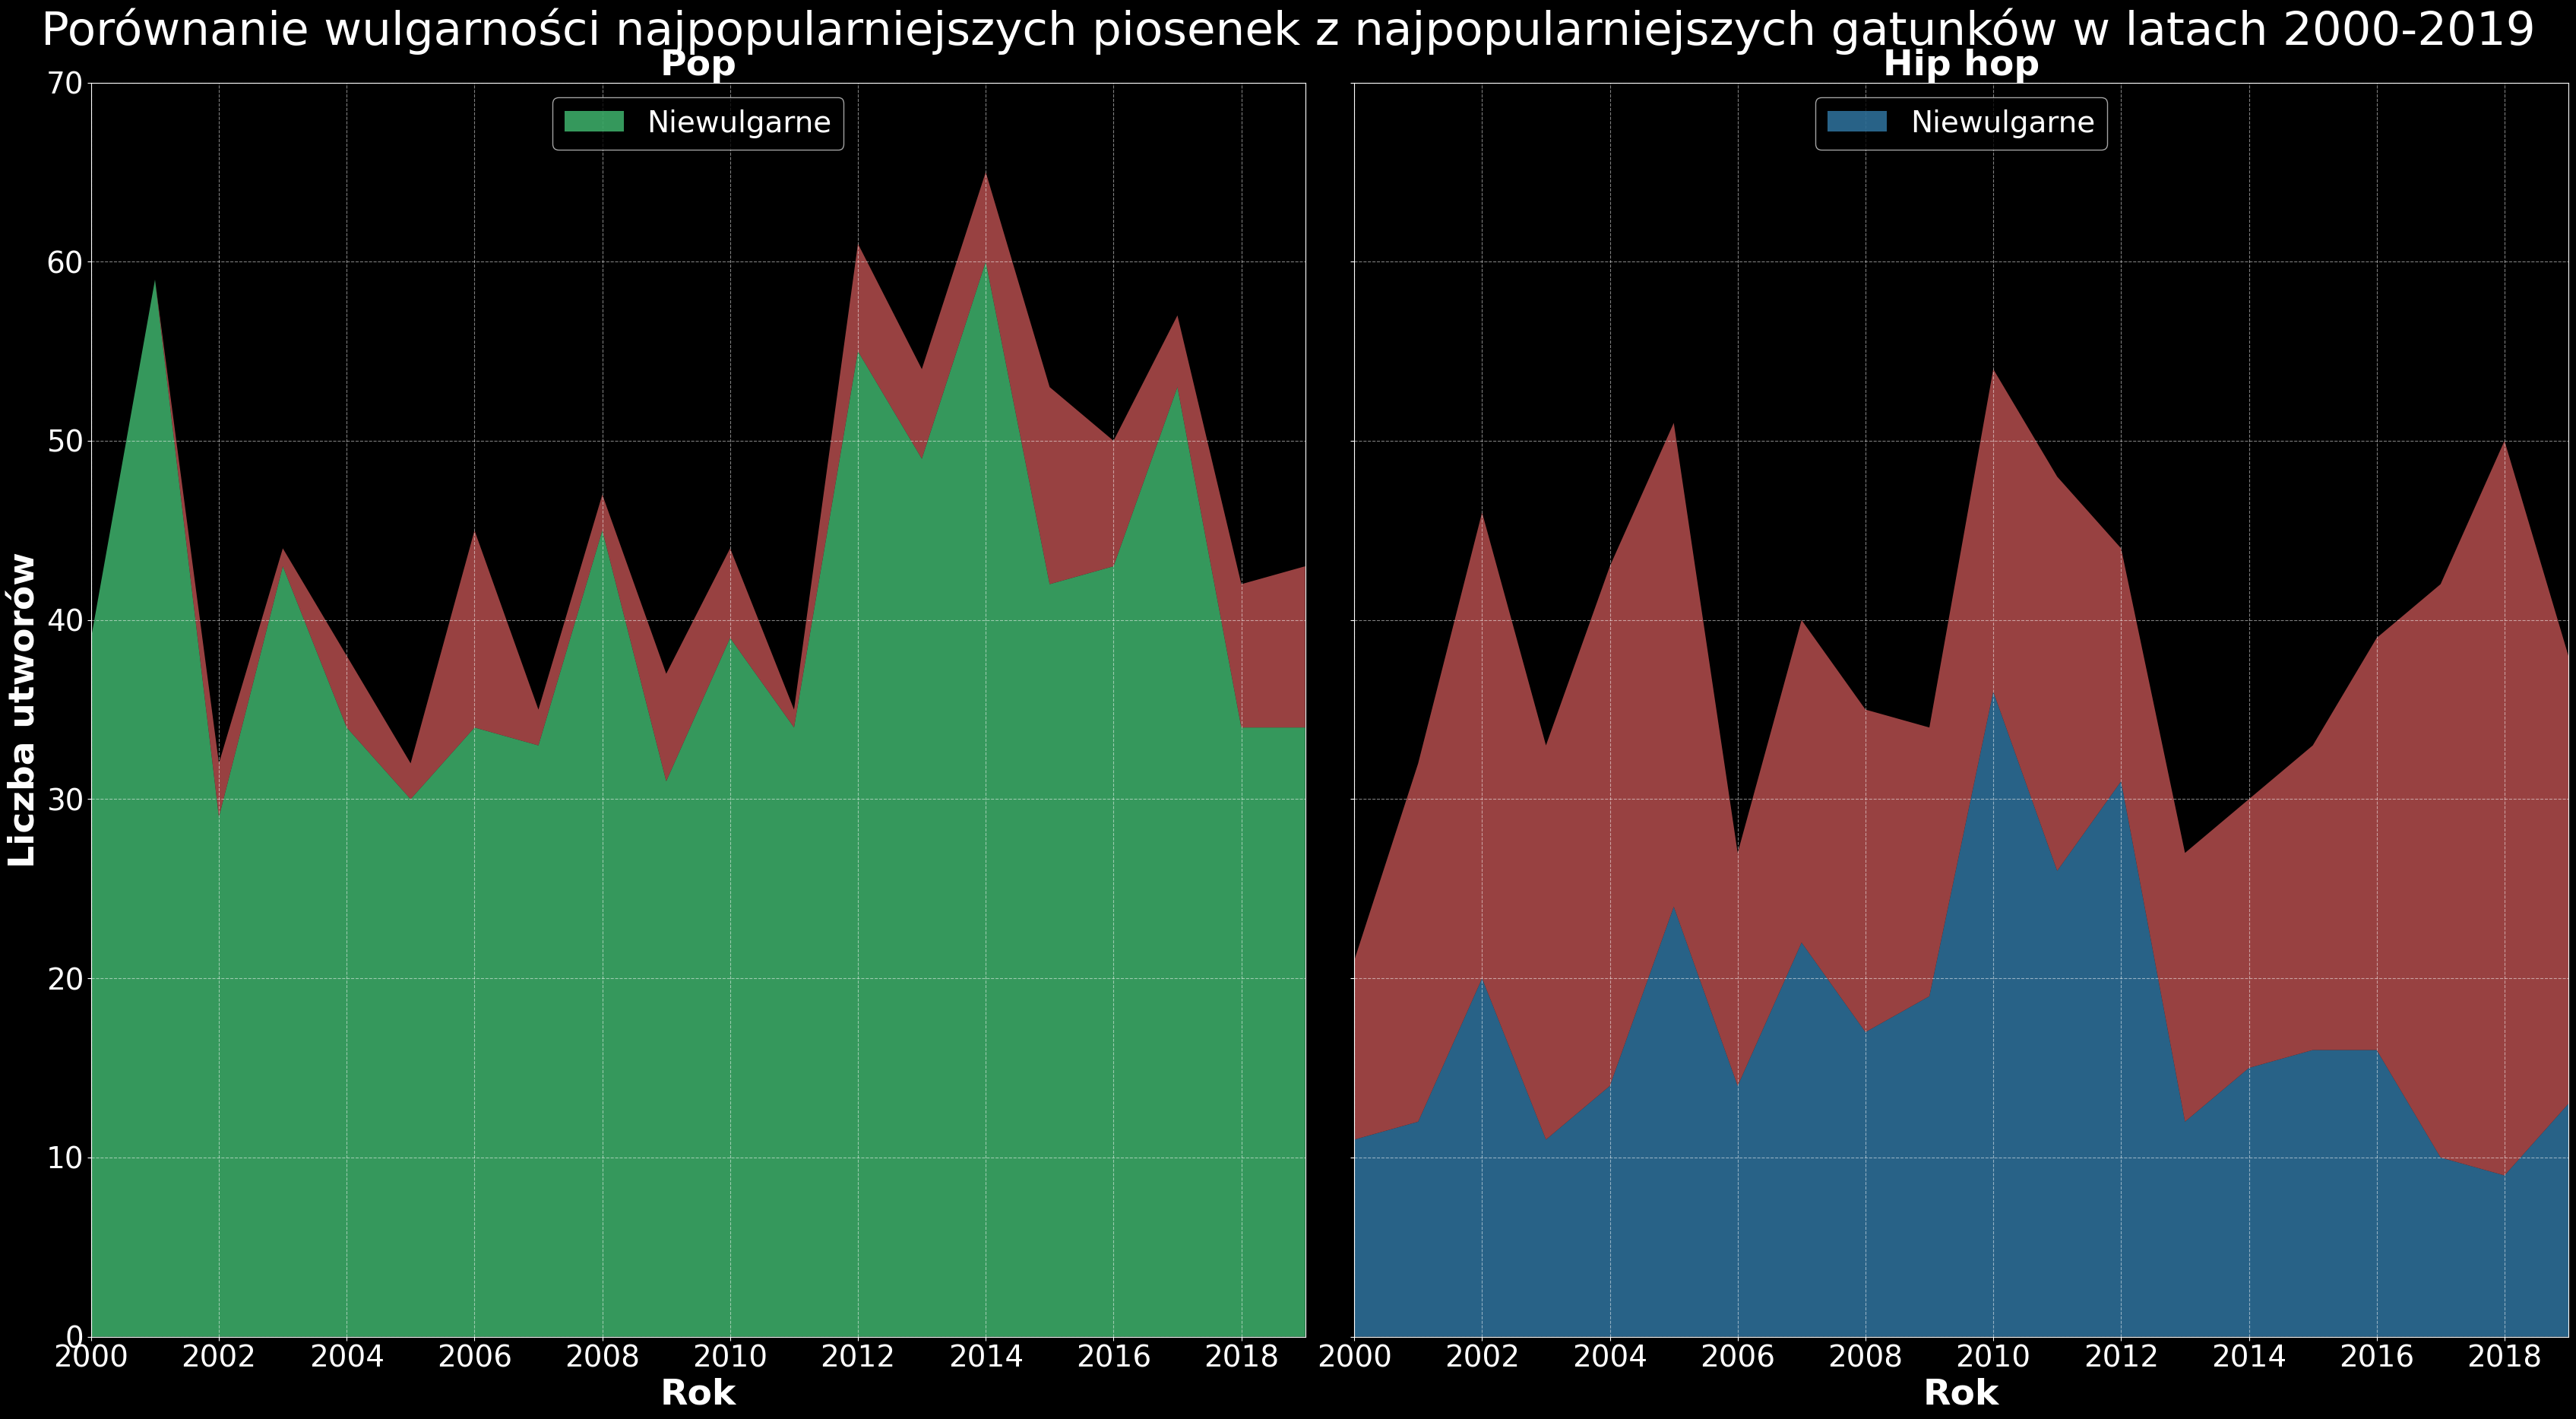

explicit  year             genre  False  True
0         2000  Dance/electronic      1     0
1         2000     Folk/acoustic      1     0
2         2000           Hip hop     11    10
3         2000             Metal      1     1
4         2000               Pop     39     0
..         ...               ...    ...   ...
120       2019  Dance/electronic      0     1
121       2019           Hip hop     13    25
122       2019             Latin      4     2
123       2019               Pop     34     9
124       2019             Set()      1     0

[125 rows x 4 columns]


In [5]:
#DANE
aktualne_dane = songnormalize

#TRANSFORMACJA DANYCH
aktualne_dane['genre'] = aktualne_dane['genre'].apply(lambda item: item.capitalize().split(',')[0])
aktualne_dane = aktualne_dane[aktualne_dane['year'] <= 2019]
aktualne_dane = aktualne_dane[aktualne_dane['year'] >= 2000]
liczba_piosenek = aktualne_dane.groupby(['year','genre','explicit']).size().unstack(fill_value=0).reset_index()
gatunki = ['Pop','Hip hop']

#STYL I KOLORY
plt.style.use('dark_background')
kolory=['#59FF9B','#44A5E2']
koloryczerw=['#FF6D6D','#FF6D6D']

# WYKRES
fig, axs = plt.subplots(1, 2, figsize=(34, 19), sharex=True, sharey=True)
fig.suptitle('Porównanie wulgarności najpopularniejszych piosenek z najpopularniejszych gatunków w latach 2000-2019',
             fontsize=44)

  # Iteracja przez gatunki
for idx, gatunek in enumerate(gatunki):
    col = idx
    row = 1
    ax = axs[col]
    gatunkidane = liczba_piosenek[liczba_piosenek['genre'] == gatunek]

    # DANE DO STACKPLOTA
    lata = gatunkidane['year']
    niewulgarne = gatunkidane[False]
    wulgarne = gatunkidane[True]


    # STACKPLOT
    ax.stackplot(lata, niewulgarne, wulgarne, labels=["Niewulgarne", 'Wulgarne'],
                 colors=[kolory[idx], koloryczerw[idx]],alpha=0.6,edgecolor='none')

    # TYTUŁY PODFIGUR
    ax.set_title(gatunek, fontsize=34, fontweight='bold')
    # LIMITY
    xlim = (2000, 2019)
    x_ticks = list(range(2000, 2020, 2))
    x_minor_ticks = list(range(2000, 2020))
    # OSIE
    ax.set_xlim(xlim)
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(x_ticks, fontsize=28)
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: int(x)))  # ensures integer formatting


    ax.set_yticks(ax.get_yticks())  # ensures the ticks are properly set
    ax.set_yticklabels(ax.get_yticks().astype(int), fontsize=28)
    ax.set_xlabel('Rok', fontsize=34, fontweight='bold')
    if gatunek != 'Hip hop':
        ax.set_ylabel('Liczba utworów', fontsize=34, fontweight='bold')


    # LEGENDA (umieszczona na górze jednego z wykresów)
    ax.legend(['Niewulgarne'], loc='upper center', fontsize=28, frameon=True, ncol=2)

    # SIATKA
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.grid(True, which='minor', linestyle=':', alpha=0.25)

plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()
gad1= liczba_piosenek[liczba_piosenek['genre'] == 'Pop']
print(liczba_piosenek)

# **SCACTTERPLOT -  średnie oceny rateyourmusic**

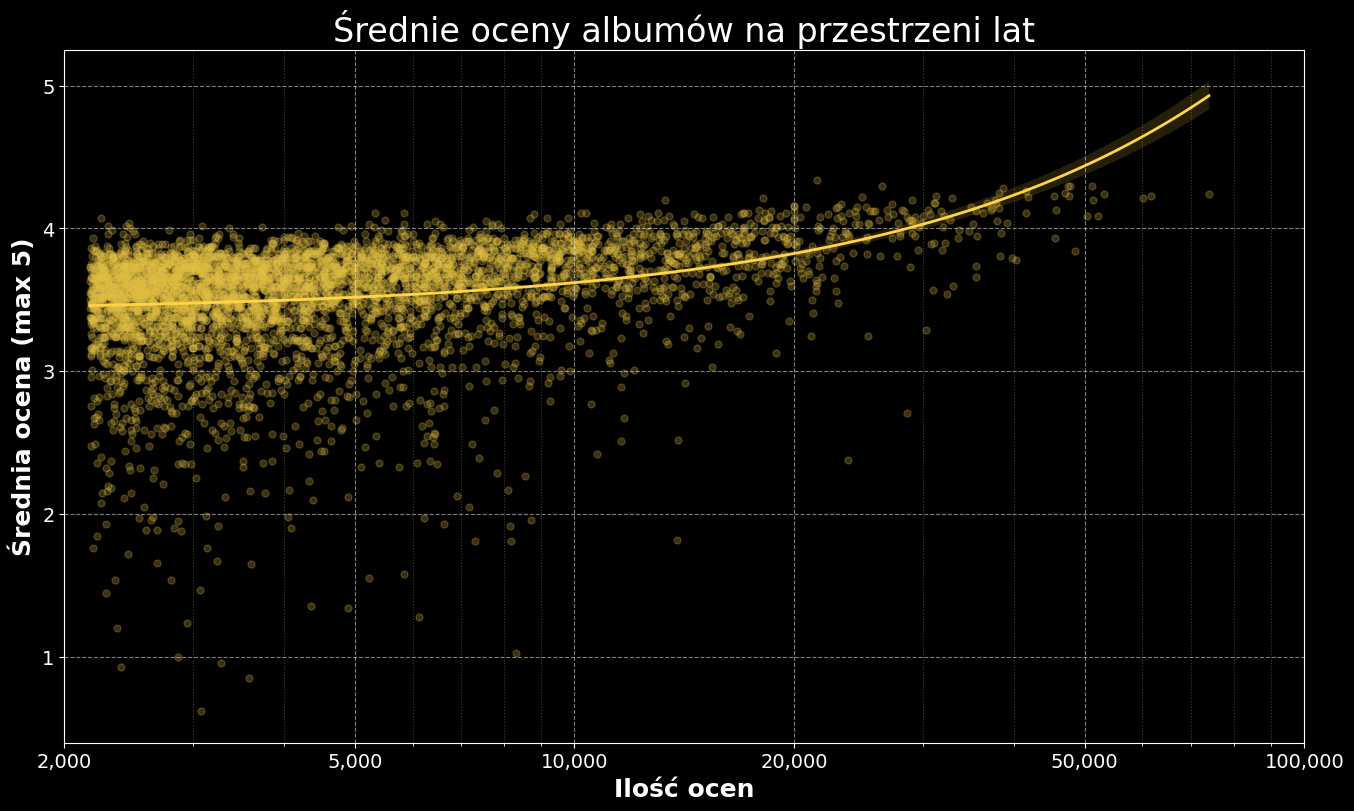

In [ ]:
#DANE
aktualne_dane = rym

#TRANSFORMACJA DANYCH


#STYL I KOLORY
plt.style.use('dark_background')

#WYKRES
fig, ax = plt.subplots(figsize=(16, 9))
  # Scatter plot z kolorami zależnymi od lat
scatter = ax.scatter(aktualne_dane['rating_count'], aktualne_dane['avg_rating'], c='#e2c044', alpha=0.25, s=25 )

  # Dodanie linii regresji
sns.regplot(x='rating_count', y='avg_rating', data=aktualne_dane, scatter=False, color='#ffd449',
            line_kws={"linewidth": 2}, ax=ax)

  # Ustawienia osi
ax.set_xlim(2 * 1000, 100000)
ax.set_xscale('log')
ax.set_xlabel('Ilość ocen', fontsize=18, fontweight='bold')
ax.set_ylabel('Średnia ocena (max 5)', fontsize=18, fontweight='bold')

# Dodanie niestandardowych znaczników osi X
x_ticks = [2000, 5000, 10000, 20000, 50000, 100000]  # Znaczniki na osi X
ax.set_xticks(x_ticks)  # Ustawienie ticków
ax.set_xticklabels([f"{int(tick):,}" for tick in x_ticks])  # Formatowanie z przecinkami
plt.tick_params(axis='both', labelsize=14)
# Siatka
ax.grid(True, linestyle='--', alpha=0.5)
ax.grid(True, which='minor', linestyle=':', alpha=0.25)

# Tytuł
plt.title("Średnie oceny albumów na przestrzeni lat", fontsize=24)

plt.show()



# **CORELATION HEATMAP - cechy utworów**

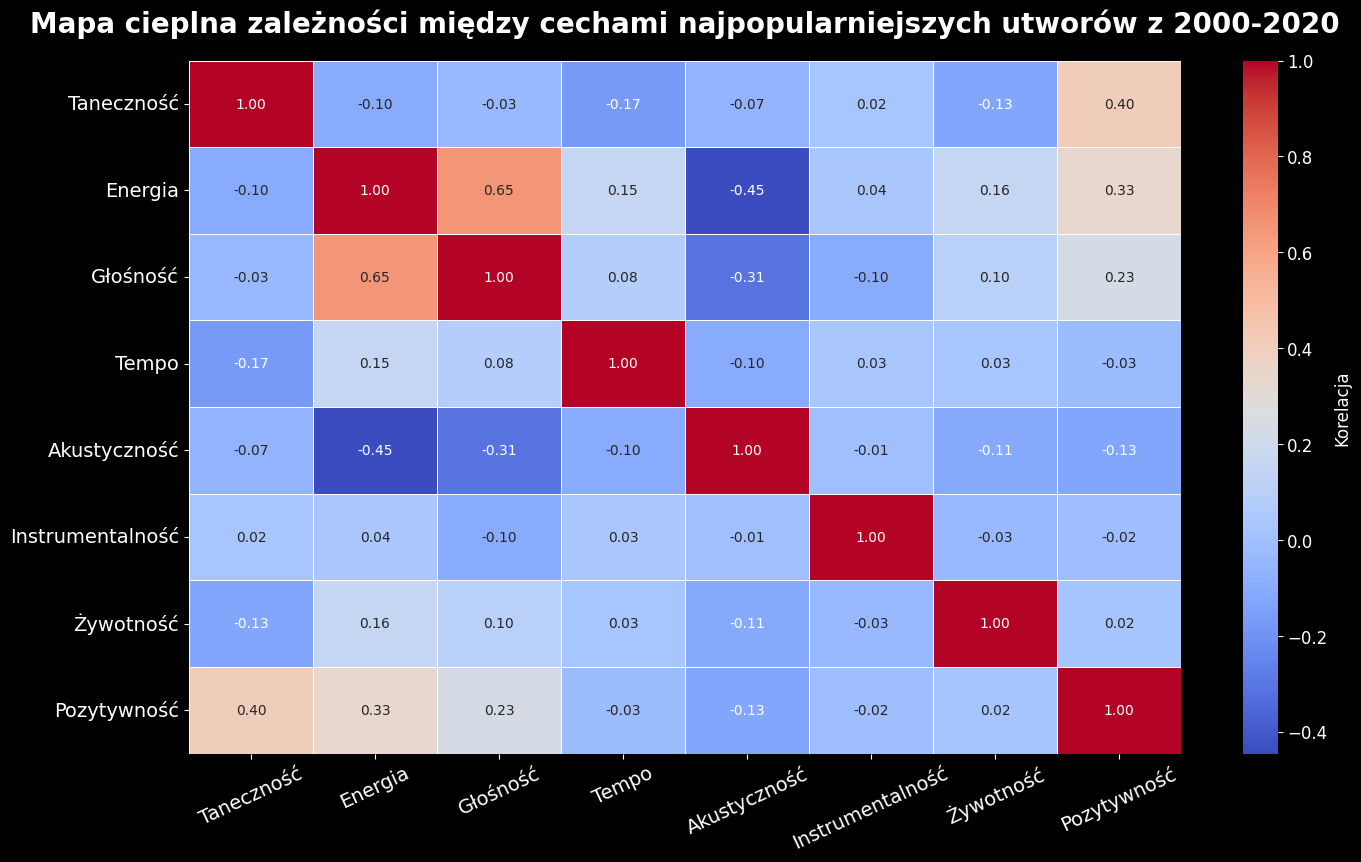

In [ ]:
#DANE
aktualne_dane =  songnormalize

#Tranformacja danych
nazwy_po_polsku = {
    'danceability': 'Taneczność',
    'energy': 'Energia',
    'loudness': 'Głośność',
    'tempo': 'Tempo',
    'acousticness': 'Akustyczność',
    'instrumentalness': 'Instrumentalność',
    'liveness': 'Żywotność',
    'valence': 'Pozytywność'
}
cechy=aktualne_dane[['danceability', 'energy', 'loudness', 'tempo','acousticness','instrumentalness','liveness','valence']]
cechy_polskie = cechy.rename(columns=nazwy_po_polsku)
macierzkorelacji = cechy_polskie.corr()
#Style i Kolory
plt.style.use('dark_background')
#WYKRES
plt.figure(figsize=(16, 9))
heatmapa = sns.heatmap(macierzkorelacji
            , annot=True,
            cmap="coolwarm",
            fmt=".2f",
            linewidths=0.5)
  # Dostosowanie rozmiaru tekstu na colorbarze
cbar = heatmapa.collections[0].colorbar
cbar.ax.tick_params(labelsize=12)  # To zmienia rozmiar liczb na colorbarze
cbar.set_label('Korelacja', size=12)  # To zmienia rozmiar etykiety colorbara

# Zwiększenie rozmiaru tytułu
plt.title("Mapa cieplna zależności między cechami najpopularniejszych utworów z 2000-2020",
          fontsize=20,
          pad=20, # Odstęp od wykresu
          weight='bold')
  # Zwiększenie rozmiaru etykiet osi
plt.xticks(fontsize=14,rotation=25)
plt.yticks(fontsize=14)
plt.show()

# **MAPA SŁOW - artyści z największą liczbą utworów na playlistach 2023**


                                       track_artist  track_name
0                                               !!!           2
1                                          !deladap           4
2      "Dear Evan Hansen" August 2018 Broadway Cast           1
3                                      #TocoParaVos           1
4                                             $ANFI           3
...                                             ...         ...
10686                                           真之介           1
10687                                            空音           1
10688                                         竹内アンナ           1
10689                     落日飛車 Sunset Rollercoaster           1
10690                                          香取慎吾           1

[10691 rows x 2 columns]


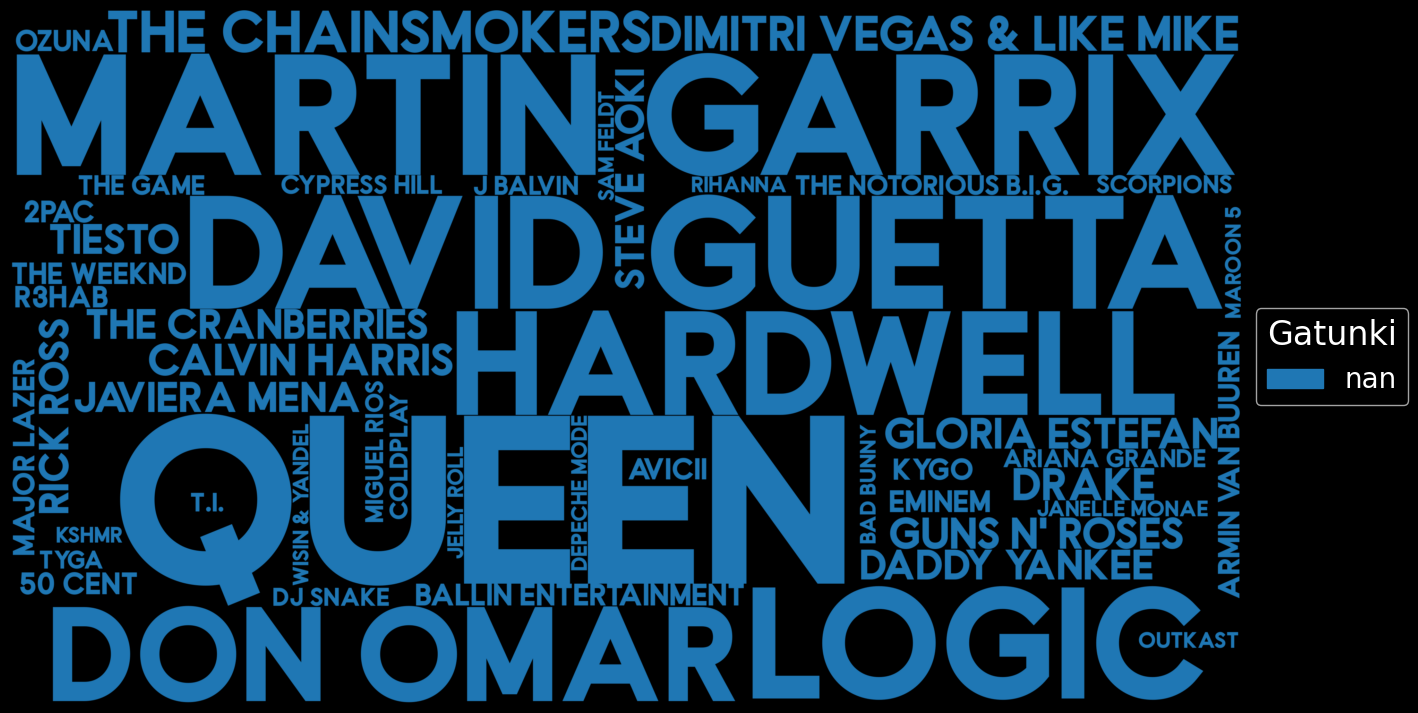

In [6]:
#DANE
aktualne_dane = spotify_songs
#TRANFOSMRACJA DANYCH
# Aktualizacja nazw artystów inaczej
spotify_songs['track_artist'] = spotify_songs['track_artist'].replace({
    'Tiësto': 'Tiesto',
    'Janelle Monáe': 'Janelle Monae'
})
# Filtracja danych: usunięcie artystów z gatunkiem "other"
aktualne_dane = aktualne_dane[spotify_songs['track_artist'] != 'オメガトライブ']
aktualne_dane = aktualne_dane[aktualne_dane['playlist_genre'] != 'other']


# Grupa top 50 artystów według liczby utworów
artysci_tabela = aktualne_dane.groupby('track_artist')['track_name'].nunique().reset_index()
print(artysci_tabela)
artysci_tabela.columns = ['track_artist', 'track_count']
artysci_tabela = artysci_tabela.sort_values(by='track_count', ascending=False).head(50)

# Najczęstszy gatunek dla każdego artysty
genre_count = aktualne_dane.groupby(['track_artist', 'playlist_genre']).size().reset_index(name='count')
dominant_genres = genre_count.loc[genre_count.groupby('track_artist')['count'].idxmax()]
dominant_genres = dominant_genres.set_index('track_artist')['playlist_genre']

# Dodanie kolumny gatunek do artysci_tabela
artysci_tabela['gatunek'] = artysci_tabela['track_artist'].map(dominant_genres)

# Mapowanie gatunków na polski
genre_translation = {
    'Pop': 'Pop',
    'Rock': 'Rock',
    'Rap': 'Hip-hop',
    'Latin': 'Latin',
    'R&b': 'R&B',
    'Edm': 'EDM'
}
artysci_tabela['gatunek_polish'] = artysci_tabela['gatunek'].map(genre_translation)

# Dane do chmury słów
artysci = artysci_tabela['track_artist']
counts = artysci_tabela['track_count']
gatunki = artysci_tabela['gatunek_polish']
d = dict(zip(artysci, counts))

# Kolory na podstawie gatunków
unique_genres = gatunki.unique()
colormap = plt.cm.tab10
genre_color_map = {genre: colormap(i / len(unique_genres)) for i, genre in enumerate(unique_genres)}
artist_colors = {artist: genre_color_map[genre] for artist, genre in zip(artysci, gatunki)}

# Funkcja do kolorowania słów
def color_func(word, *args, **kwargs):
    color = artist_colors.get(word, (1, 1, 1))  # Biały, jeśli brak koloru
    return tuple(int(c * 255) for c in color[:3])

# Tworzenie chmury słów
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(16, 9))
wordcloud = wr.WordCloud(font_path=font,
    collocations=False,
    background_color='black',
    color_func=color_func,
    width=3840,
    height=2160,
).generate_from_frequencies(d)
ax.imshow(wordcloud, interpolation='bilinear')
ax.axis("off")

# Dodanie legendy
legend_labels = [plt.Rectangle((0, 0), 1, 1, color=genre_color_map[genre]) for genre in unique_genres]
ax.legend(
    legend_labels,
    unique_genres,
    loc='center left',
    bbox_to_anchor=(1, 0.5),
    title="Gatunki",
    fontsize=20,
    title_fontsize=24)
plt.show()

# **CENY SPOTIFY WG PAŃSTW**

In [ ]:
#jeżeli wykres jest czarny
plt.rcdefaults()

**Mapa**

In [ ]:
#DANE
aktualne_dane = spotify_prices

#TRANSFORMACJA DANYCH
aktualne_dane['Price'] = aktualne_dane['Spotify Individual price/month'].str.extract(r'USD\s*(\d+\.?\d*)').astype(float)

#STYL I KOLORY

#WYKRES

fig = px.choropleth(
    aktualne_dane,
    locations='Country',
    locationmode='country names',
    color='Price',
    hover_name='Country',
    hover_data={'Price': ':.2f'},
    color_continuous_scale=[
        [0, 'rgb(145,207,96)'],    # Light green for lowest prices
        [0.25, 'rgb(217,239,139)'], # Yellow-green
        [0.5, 'rgb(254,224,139)'],  # Light yellow
        [0.75, 'rgb(252,141,89)'],  # Orange
        [1, 'rgb(215,48,39)']       # Red for highest prices
    ],
    range_color=[0, 16],
    title='Koszt miesięcznej subskrypcji na Spotify Premium na całym świecie (USD)'
)

fig.update_layout(
    title={
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': {'size': 20}
    },
    geo=dict(
        showframe=False,
        showcoastlines=True,
        projection_type='equirectangular'
    ),
    width=1200,
    height=800,
    coloraxis_colorbar_title='Cena (USD)',
)

fig.show()

# Zapisanie wykresu
#fig.write_html("Spotify_prices_bycountry.html")

# Pobranie pliku z Colab
#from google.colab import files
#files.download('Spotify_prices_bycountry.html')

**Top najdroższych państw**

In [ ]:

# Dane
aktualne_dane = spotify_prices

# Transformacja danych
dane_sorted = aktualne_dane.sort_values('Price', ascending=False).head(20)

# Tłumaczenie nazw państw na polski
country_translation = {
    "Denmark": "Dania",
    "Switzerland": "Szwajcaria",
    "Liechtenstein": "Liechtenstein",
    "United Kingdom": "Wielka Brytania",
    "Finland": "Finlandia",
    "Iceland": "Islandia",
    "Norway": "Norwegia",
    "Andorra": "Andora",
    "Austria": "Austria",
    "Belgium": "Belgia",
    "Spain": "Hiszpania",
    "France": "Francja",
    "San Marino": "San Marino",
    "Netherlands": "Holandia",
    "Monaco": "Monako",
    "Ireland": "Irlandia",
    "Italia": "Włochy",
    "Luxembourg": "Luksemburg",
    "Sweden": "Szwecja",
    "Ceuta": "Ceuta"
}
dane_sorted['Country'] = dane_sorted['Country'].map(country_translation).fillna(dane_sorted['Country'])

# Wykres
bar_fig = px.bar(
    dane_sorted,
    x='Price',
    y='Country',
    orientation='h',
    title='Top 20 najdroższych subskrybcji na Spotify Premium według kraju',
    labels={'Price': 'Miesięczny koszt (USD)', 'Country': ''},
    color='Price',
    color_continuous_scale=[
        [0, 'rgb(253,163,103)'],  # Kolor #FDA367
        [0.25, 'rgb(252,141,89)'],
        [0.5, 'rgb(227,74,51)'],
        [0.75, 'rgb(215,48,39)'],
        [1, 'rgb(215,48,39)']     # Czerwony dla najwyższych wartości
    ],
    range_color=[11.03, 16.11]  # Zakres kolorów przycięty do wartości wykresu 2
)

# Adnotacje
bar_fig.update_traces(
    texttemplate='%{x:.2f}',  # 2 miejsca po przecinku
    textposition='outside',   # Tekst poza słupkami
    hovertemplate=None,       # Usuń hover template
    hoverinfo='none',
    textfont=dict(size=20, color='black')    # Zmniejszenie rozmiaru podpisu, biały tekst
)

# Layout
bar_fig.update_layout(
    width=1400,               # Szerszy wykres
    height=800,
    yaxis={'categoryorder': 'total ascending'},
    showlegend=False,
    margin=dict(r=100),
    hoverlabel=dict(namelength=0),
    coloraxis_showscale=False,
    title_font_size=30,       # Mniejszy tytuł
    font=dict(size=24, color='black'),       # Zmniejszenie rozmiaru ogólnej czcionki, biały tekst
    xaxis_title_font_size=24  # Mniejszy podpis osi X
)

# Pokaż wykres
bar_fig.show()
